# Determining Neural Regions’ of Interest Relationship to Cognitive Impairment Symptoms Using Tau Scans

Authors: Ardo Nashalian, Carlos Ayala Bellido, Kyan Younes (in advisory role)

Note: This was our final project for the Stanford University course PSYC 221 (Machine Learning for Neuroimaging).

## Library Downloads

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Library Imports

In [2]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
np.random.seed(0)

import os

import pandas as pd

from scipy import stats

import seaborn as sns

from sklearn import svm, metrics
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from statsmodels.stats import contingency_tables # Contringency tables

import torch # PyTorch
from torch import nn # Modules and layers
from torch.utils.data import Dataset, DataLoader # PyTorch Dataloader
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
torch.manual_seed(0)

## Important Functions

Defining all the functions used throughout the program

### Multi-output Support Vector Regression

In [3]:
"""
Multi-output Support Vector Regression
"""
# Copyright (C) 2020 Xinze Zhang, Kaishuai Xu, Siyue Yang, Yukun Bao
# <xinze@hust.edu.cn>, <xu.kaishuai@gmail.com>, <siyue_yang@hust.edu.cn>, <yukunbao@hust.edu.cn>

# This program is free software: you can redistribute it and/or modify
# it under the terms of the Apache.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# Apache License for more details.



import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

class MSVR():
    def __init__(self, kernel='rbf', degree=3, gamma=None, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1):
        super(MSVR, self).__init__()
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.C = C
        self.epsilon = epsilon
        self.Beta = None
        self.NSV = None
        self.xTrain = None

    def fit(self, x, y):
        self.xTrain = x.copy()
        C = self.C
        epsi = self.epsilon
        tol = self.tol

        n_m = np.shape(x)[0]  # num of samples
        n_d = np.shape(x)[1]  # input data dimensionality
        n_k = np.shape(y)[1]  # output data dimensionality (output variables)

        # H = kernelmatrix(ker, x, x, par)
        H = pairwise_kernels(x, x, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)

        self.Beta = np.zeros((n_m, n_k))

        #E = prediction error per output (n_m * n_k)
        E = y - np.dot(H, self.Beta)
        #RSE
        u = np.sqrt(np.sum(E**2, 1, keepdims=True))

        #RMSE
        RMSE = []
        RMSE_0 = np.sqrt(np.mean(u**2))
        RMSE.append(RMSE_0)

        #points for which prediction error is larger than epsilon
        i1 = np.where(u > epsi)[0]

        #set initial values of alphas a (n_m * 1)
        a = 2 * C * (u - epsi) / u

        #L (n_m * 1)
        L = np.zeros(u.shape)

        # we modify only entries for which  u > epsi. with the sq slack
        L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

        #Lp is the quantity to minimize (sq norm of parameters + slacks)
        Lp = []
        BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
        Lp_0 = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
        Lp.append(Lp_0)

        eta = 1
        k = 1
        hacer = 1
        val = 1

        while(hacer):
            Beta_a = self.Beta.copy()
            E_a = E.copy()
            u_a = u.copy()
            i1_a = i1.copy()

            M1 = H[i1][:, i1] + \
                np.diagflat(1/a[i1]) + 1e-10 * np.eye(len(a[i1]))

            #compute betas
            #       sal1 = np.dot(np.linalg.pinv(M1),y[i1])  #求逆or广义逆（M-P逆）无法保证M1一定是可逆的？
            sal1 = np.dot(np.linalg.inv(M1), y[i1])

            eta = 1
            self.Beta = np.zeros(self.Beta.shape)
            self.Beta[i1] = sal1.copy()

            #error
            E = y - np.dot(H, self.Beta)
            #RSE
            u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)
            i1 = np.where(u >= epsi)[0]

            L = np.zeros(u.shape)
            L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

            #%recompute the loss function
            BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
            Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
            Lp.append(Lp_k)

            #Loop where we keep alphas and modify betas
            while(Lp[k] > Lp[k-1]):
                eta = eta/10
                i1 = i1_a.copy()

                self.Beta = np.zeros(self.Beta.shape)
                #%the new betas are a combination of the current (sal1)
                #and of the previous iteration (Beta_a)
                self.Beta[i1] = eta*sal1 + (1-eta)*Beta_a[i1]

                E = y - np.dot(H, self.Beta)
                u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)

                i1 = np.where(u >= epsi)[0]

                L = np.zeros(u.shape)
                L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2
                BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
                Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
                Lp[k] = Lp_k

                #stopping criterion 1
                if(eta < 1e-16):
                    Lp[k] = Lp[k-1] - 1e-15
                    self.Beta = Beta_a.copy()

                    u = u_a.copy()
                    i1 = i1_a.copy()

                    hacer = 0

            #here we modify the alphas and keep betas
            a_a = a.copy()
            a = 2 * C * (u - epsi) / u

            RMSE_k = np.sqrt(np.mean(u**2))
            RMSE.append(RMSE_k)

            if((Lp[k-1]-Lp[k])/Lp[k-1] < tol):
                hacer = 0

            k = k + 1

            #stopping criterion #algorithm does not converge. (val = -1)
            if(len(i1) == 0):
                hacer = 0
                self.Beta = np.zeros(self.Beta.shape)
                val = -1

        self.NSV = len(i1)

    def predict(self, x):
        H = pairwise_kernels(x, self.xTrain, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)
        yPred = np.dot(H, self.Beta)
        return yPred

    # def score(self,x):

### Dataset Creation and Modification

In [4]:
import numpy as np
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# import statistics

def create_dataset(ts, dim ,h):
    look_back = dim + h -1
    # dataset = np.insert(dataset, [0] * look_back, 0)
    dataX, dataY = [], []
    for i in range(len(ts) - look_back):
        a = ts[i:(i + look_back)]
        dataX.append(a)
        dataY.append(ts[i + look_back])
    dataY = np.array(dataY)
    dataY = np.reshape(dataY, (dataY.shape[0], 1))
    dataset = np.concatenate((dataX, dataY), axis=1)
    return dataset


def unpadding(y):
    a = y.copy()
    h = y.shape[1]
    s = np.empty(y.shape[0] + y.shape[1] -1)

    for i in range(s.shape[0]):
        s[i]=np.diagonal(np.flip(a,1), offset= -i + h-1,axis1=0,axis2=1).copy().mean()

    return s

def mape(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    mask =  y_true != 0.0
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true):
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    N_metric =  (y_true[mask] - y_pred[mask])/y_true[mask]
    N_metric = np.fabs(N_metric)
    metric = N_metric.mean()

    return metric

def smape(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    mask =  y_true != 0.0
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true):
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    N_metric =  (y_true[mask] - y_pred[mask])/(y_true[mask] + y_pred[mask])
    N_metric = np.fabs(N_metric)
    metric = N_metric.mean()

def rmse(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    return np.sqrt(mean_squared_error(y_true,y_pred))

### Pandas Dataset

In [5]:
class PandasDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, y_dtype=torch.int64):
        self.X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Neural Net Classifier

In [6]:
# Build a classifier in PyTorch
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size=None, nr_classes=4, hidden_layer_sizes=[16,8], save_path="models"):
        super().__init__()
        self.name = self.__class__.__name__ + '-'.join([str(n) for n in hidden_layer_sizes])
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Define the architecture of the model
        layers = []
        nr_neurons = [input_size] + hidden_layer_sizes
        for ix in range(len(nr_neurons)-1):
            # A linear, fully-connected layer
            layers.append(nn.Linear(nr_neurons[ix], nr_neurons[ix+1]))
            # A ReLU activation function
            layers.append(nn.ReLU())
        # Final layer, in this (nr_classes==6) classification
        layers.append(nn.Linear(nr_neurons[-1], nr_classes))
        # Finally, we place them one after the other
        self.layers = nn.Sequential(*layers)
        # The softmax function ensures we have one output per class, and these add up to 1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        '''Forward pass'''
        # x = self.flatten(x)
        logits = self.layers(x)
        return logits

    def predict(self, X):
        '''Make a prediction based on a given input'''
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return int(pred.argmax().detach())

    def save(self, state_name='last', verbose=False):
        '''Saves a model state in the defined path, with the model name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        torch.save(self.state_dict(), os.path.join(self.save_path, model_state_name))
        if verbose:
            print("Saved PyTorch model state {} in {}".format(model_state_name, self.save_path))

    def restore(self, state_name):
        '''Restores a model state for the given state name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        self.load_state_dict(torch.load(os.path.join(self.save_path, model_state_name)))

### Model Training and Evaluation

In [28]:
# Methods to train and evaluate model
def train_model(model, train_dl, optimizer, loss_f, nr_epochs, print_loss_every=10):
    for t in range(nr_epochs):
        model.train()
        nr_batches = len(train_dl)
        total_loss = 0
        optimizer.zero_grad()
        for _, (X, y) in enumerate(train_dl):
            # Backpropagation step
            pred = model(X)
            loss = loss_f(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        if t % print_loss_every == 0:
            print(f"Epoch {t} loss {total_loss / nr_batches}")
    model.save()
    print("Finished training!")

def eval_model(model, dl, historic = False, visuals = True, title_name = ''):
    model.eval() # This is important for certain stochastic elements, such as MC Dropout
    targets = []
    predictions = []
    for X, y in dl:
        pred = model(X)
        targets += list(y.detach().cpu().numpy())
        predictions += list(pred.detach().cpu().numpy())
    if historic:
        print(predictions)
        print(list(np.mean(np.array(targets), axis=1)))
        MAE = metrics.mean_squared_error(list(np.mean(np.array(targets), axis=1)), predictions)
        return (MAE)
    else:
        if visuals:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle(title_name)
            ax1.scatter(targets,predictions)
            ax1.plot(targets,targets)
            ax1.set_xlabel('True PHC')
            ax1.set_ylabel('Predicted PHC')
            ax1.set_title("True vs. Predicted PHC Values")
            ax2.hist(targets)
            ax2.set_xlabel('True PHC Values')
            ax2.set_ylabel('Number of Occurrences')
            ax2.set_title("Histogram of True Values")
            fig.tight_layout()
        MAE = metrics.mean_squared_error(targets, predictions)
        R2 = r2_score(targets,predictions)
        return (MAE,R2)

# def eval_model_historic(model, dl):
#     model.eval() # This is important for certain stochastic elements, such as MC Dropout
#     targets = []
#     predictions = []
#     for X, y in dl:
#         pred = model(X)
#         targets += list(y.detach().cpu().numpy())
#         predictions += list(pred.detach().cpu().numpy())
#     print(predictions)
#     print(list(np.mean(np.array(targets), axis=1)))
#     MAE = metrics.mean_squared_error(list(np.mean(np.array(targets), axis=1)), predictions)
#     return (MAE)

### Multiclass

In [8]:
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(112, 4)
        self.act = nn.ReLU()
        self.output = nn.Linear(112, 4)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

model = Multiclass()

## Initial Setup

### Import Data/Zscore

In [9]:
DataPath = 'ADNI_Tau_PHC.xlsx'
target_cols = ['','','','']
df = pd.read_excel(DataPath)
train_ds = df.sample(frac = 0.80)
test_ds = df.drop(train_ds.index)
input_size =112
out_columns = df.columns.str.contains('PHC')
feature_columns = df.columns.str.contains('_SUVR')
features_train = train_ds[train_ds.columns[feature_columns]]
features_train = stats.zscore(features_train)
features_train = features_train.dropna(axis=1)
features_test = test_ds[test_ds.columns[feature_columns]]
features_test = features_test.drop(columns=['INFERIORCEREBELLUM_SUVR'])
features_test = features_test.dropna(axis=1)
out_train = train_ds[train_ds.columns[out_columns]]
out_train = out_train.fillna(0)
out_train = stats.zscore(out_train)
out_test = test_ds[test_ds.columns[out_columns]]
out_test = out_test.fillna(0)
target_cols = [col for col in out_train.columns]
feature_cols = [col for col in features_train.columns]
train_ds = pd.concat([features_train,out_train],axis=1)
train_ds.head()

,ERODED_SUBCORTICALWM_SUVR,BRAAK1_SUVR,BRAAK34_SUVR,META_TEMPORAL_SUVR,BRAAK56_SUVR,BRAINSTEM_SUVR,VENTRICLE_3RD_SUVR,VENTRICLE_4TH_SUVR,CC_ANTERIOR_SUVR,CC_CENTRAL_SUVR,...,RIGHT_LATERAL_VENTRICLE_SUVR,RIGHT_PALLIDUM_SUVR,RIGHT_PUTAMEN_SUVR,RIGHT_THALAMUS_PROPER_SUVR,RIGHT_VENTRALDC_SUVR,WM_HYPOINTENSITIES_SUVR,PHC_MEM_mannualJoin,PHC_EXF_mannualJoin,PHC_LAN_mannualJoin,PHC_VSP_mannualJoin
55,-1.079803,-0.809630,-0.884023,-0.791517,-0.738504,0.028151,-0.141303,0.478843,-0.092070,-1.701819,...,0.002184,-0.215278,-0.699792,-1.110506,-0.947722,-0.530967,-0.405100,-0.579796,-1.712534,-0.011907
316,0.917224,0.410145,0.423597,0.252857,0.204810,1.232406,1.544558,0.791386,1.649710,1.250913,...,1.590671,0.667413,0.854783,0.883848,0.688876,1.766617,1.372322,1.861367,3.019285,0.884147
252,2.292750,1.720766,1.465137,1.195472,1.543172,1.530273,0.829861,-0.309353,0.999451,2.481615,...,0.860794,1.724445,1.821885,1.665109,2.216308,1.841643,-1.508571,-1.001975,-1.963313,-0.263073
262,-0.001906,-0.275875,-0.216529,-0.206245,-0.050029,-0.138280,-0.251108,0.910335,-0.276814,0.432775,...,0.509547,-0.457832,-0.608828,-0.001033,-0.182854,-0.451654,-0.088612,0.713226,0.191413,-1.311863
31,-0.632545,-0.506993,-0.468515,-0.437019,-0.454944,-0.628201,0.394675,0.672145,-0.484723,-1.002366,...,0.252627,0.559454,-0.266399,0.520968,0.469099,-0.079622,0.525998,0.090083,-0.237552,-0.011907


## SUVR inputs to PHC Score outputs

### NN Implementation of SUVR --> PHC Score

['PHC_MEM_mannualJoin', 'PHC_EXF_mannualJoin', 'PHC_LAN_mannualJoin', 'PHC_VSP_mannualJoin']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.479364752130849
Epoch 5 loss 0.26933625521404403
Epoch 10 loss 0.2480425374848502
Epoch 15 loss 0.23569901351417813
Epoch 20 loss 0.23149980923959187
Epoch 25 loss 0.22703327078904426
Epoch 30 loss 0.22053775436111858
Epoch 35 loss 0.216328341620309
Epoch 40 loss 0.21402718148061206
Epoch 45 loss 0.21019444029246057
Epoch 50 loss 0.21080412609236582
Epoch 55 loss 0.2049904977636678
Epoch 60 loss 0.20401710505996432
Epoch 65 loss 0.19921814437423432
Epoch 70 loss 0.19847904848200934
Epoch 75 loss 0.19541679226926395
Epoch 80 loss 0.19614744622792515
Epoch 85 loss 0.19232871612267835
Epoch 90 loss 0.19569467614803995
Epoch 95 loss 0.19247177935072354
Finished training!
['P

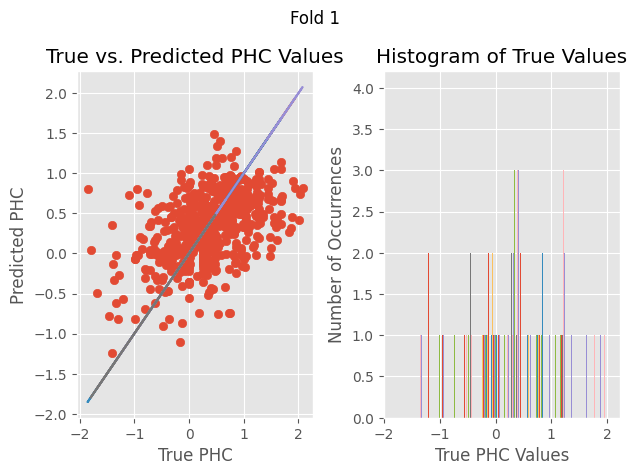

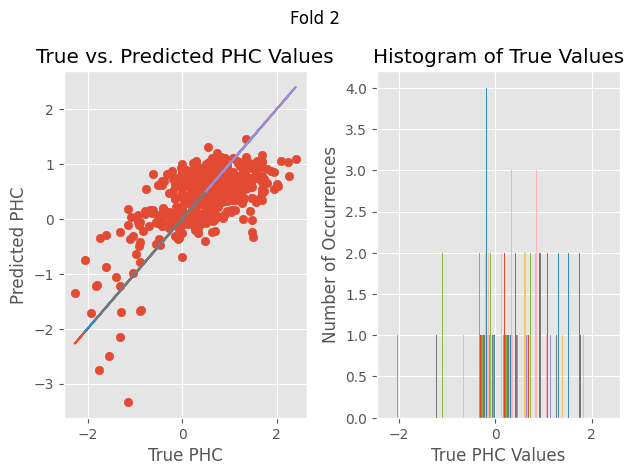

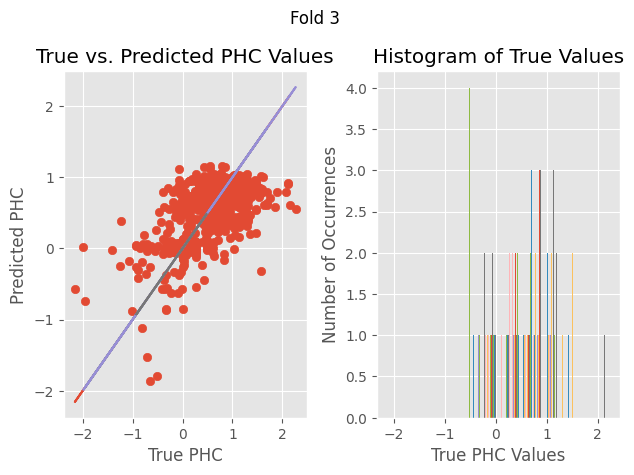

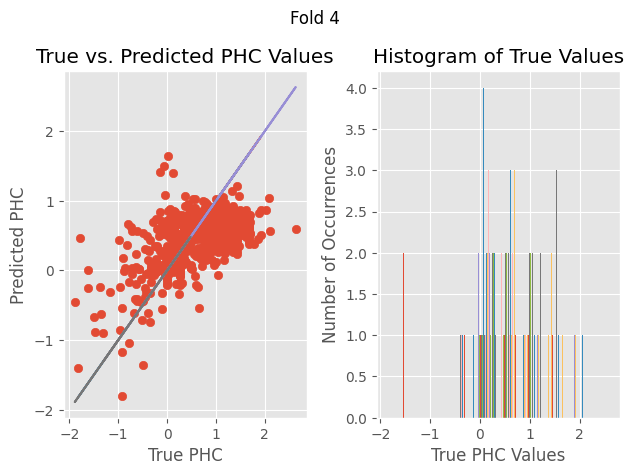

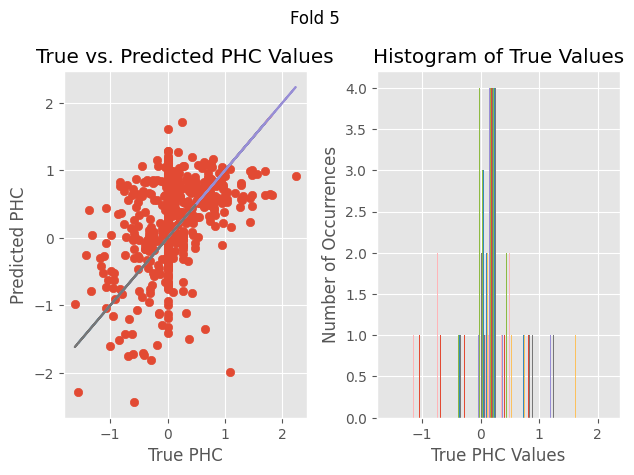

In [29]:
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df = df.drop(columns=['INFERIORCEREBELLUM_SUVR'])
df[feature_cols] = stats.zscore(df[feature_cols])
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size =118
  out_columns = df.columns.str.contains('PHC')
  feature_columns = df.columns.str.contains('_SUVR')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl, title_name="Fold "+ str((i+1)))
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

In [36]:
print((R2))

[ 0.07125423  0.20866457  0.14561236  0.17789031 -0.66464551]


### SVM Implementation of SUVR-->PHC Scores

In [37]:
import warnings

warnings.filterwarnings("ignore")

0.3550665215726102
-0.0683755974968466
[0.35328858 0.39876313 0.36230005 0.38126427 0.27971658]
[ 0.01913829 -0.03314467 -0.16092479  0.03080623 -0.19775304]


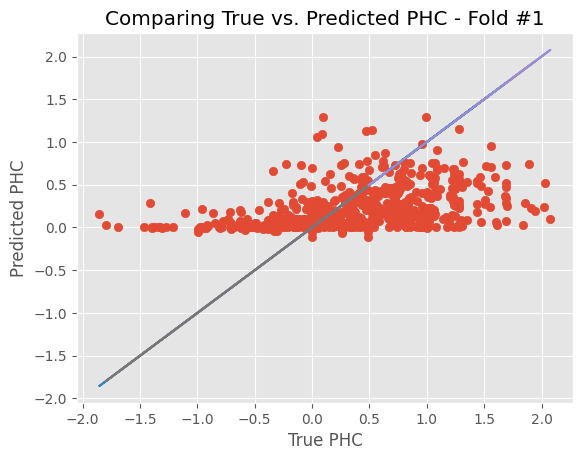

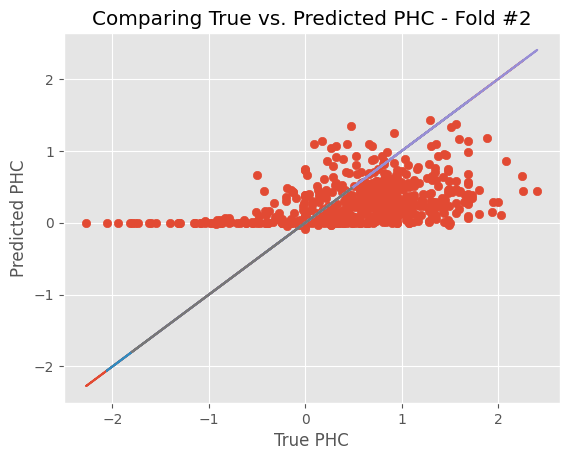

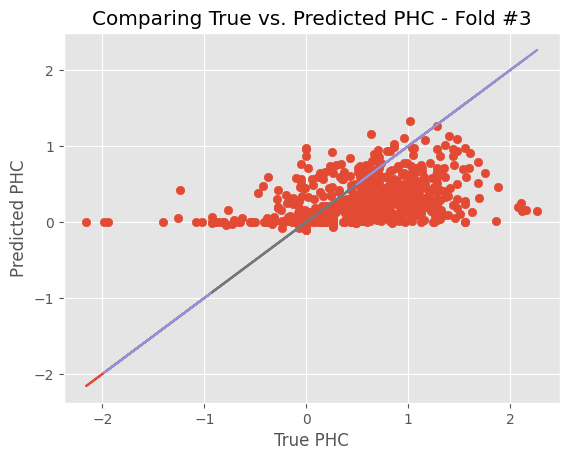

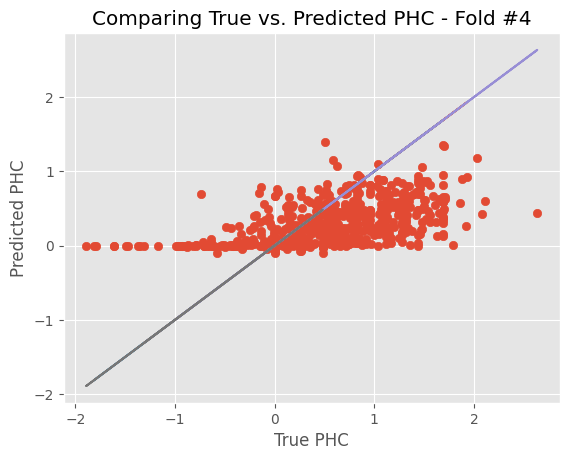

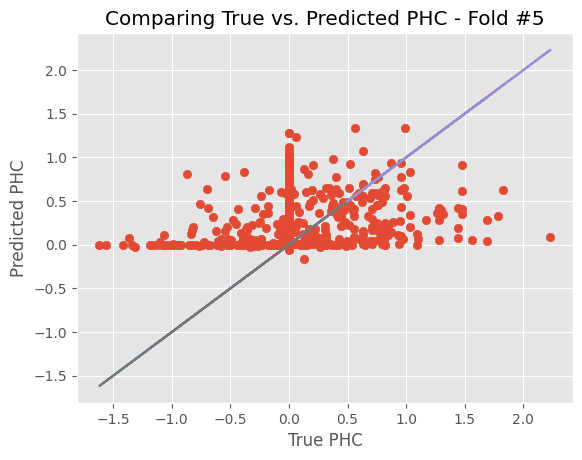

In [38]:
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  out_columns = df.columns.str.contains('PHC')
  feature_columns = df.columns.str.contains('_SUVR')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  R2[i] = r2_score(out_test,testPred)
  RMSE_SVM[i]= rmse(out_test,testPred)
  plt.figure ()
  plt.plot(out_test,out_test)
  plt.scatter(out_test,testPred)
  plt.xlabel("True PHC")
  plt.ylabel("Predicted PHC")
  fold_num = i+1
  plt.title("Comparing True vs. Predicted PHC - Fold #" + str(fold_num))
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(RMSE_SVM)
print(R2)

### Fully Connected ROI Volume To SUVR Scores
ROI Volume inputs to SUVR outputs

ROI to SUVR In a fully connected Manner but later discovered this was not a good implementation.

New Neural Network implementation for this application

In [39]:
# Build a classifier in PyTorch
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size=None, nr_classes=119, hidden_layer_sizes=[16,8], save_path="models"):
        super().__init__()
        self.name = self.__class__.__name__ + '-'.join([str(n) for n in hidden_layer_sizes])
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Define the architecture of the model
        layers = []
        nr_neurons = [input_size] + hidden_layer_sizes
        for ix in range(len(nr_neurons)-1):
            # A linear, fully-connected layer
            layers.append(nn.Linear(nr_neurons[ix], nr_neurons[ix+1]))
            # A ReLU activation function
            layers.append(nn.ReLU())
        # Final layer, in this (nr_classes==6) classification
        layers.append(nn.Linear(nr_neurons[-1], nr_classes))
        # Finally, we place them one after the other
        self.layers = nn.Sequential(*layers)
        # The softmax function ensures we have one output per class, and these add up to 1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        '''Forward pass'''
        # x = self.flatten(x)
        logits = self.layers(x)
        return logits

    def predict(self, X):
        '''Make a prediction based on a given input'''
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return int(pred.argmax().detach())

    def save(self, state_name='last', verbose=False):
        '''Saves a model state in the defined path, with the model name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        torch.save(self.state_dict(), os.path.join(self.save_path, model_state_name))
        if verbose:
            print("Saved PyTorch model state {} in {}".format(model_state_name, self.save_path))

    def restore(self, state_name):
        '''Restores a model state for the given state name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        self.load_state_dict(torch.load(os.path.join(self.save_path, model_state_name)))

['INFERIORCEREBELLUM_SUVR', 'ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARACENTRAL_SUVR', 'CTX_LH_PARAHIPPOCAMPAL_SUVR', 'CTX_LH_PARSOPERCULARIS_SUVR', 'CTX_LH_PARSORBITALIS_SUVR', 'CTX_LH_PARSTRIANGULARIS_SUVR', 'CTX_LH_PERICALCARINE_SUVR', 'CTX_LH_POSTCENTRAL

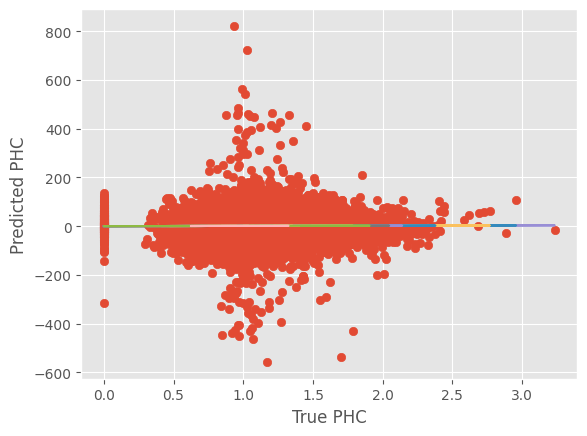

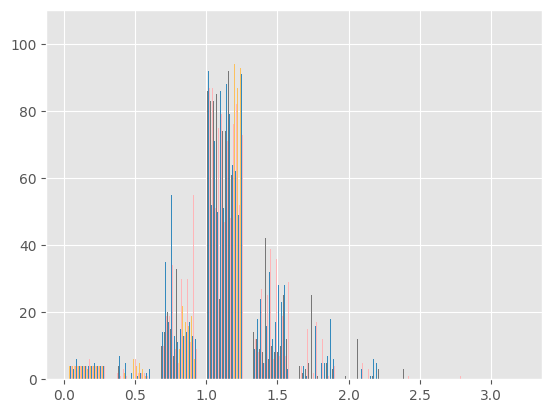

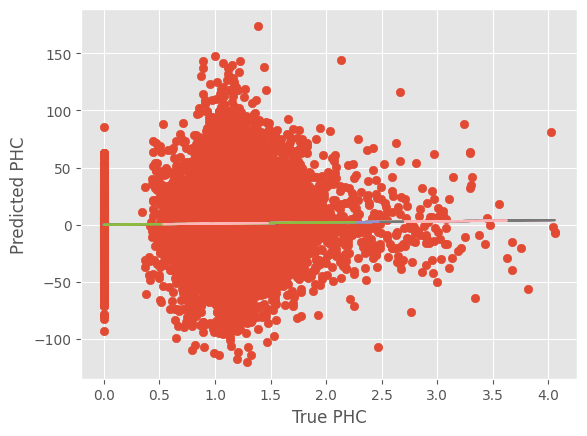

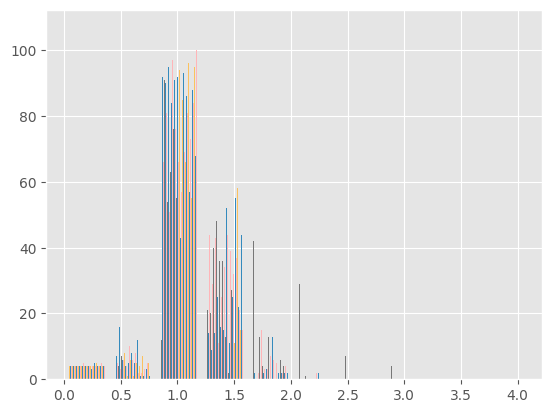

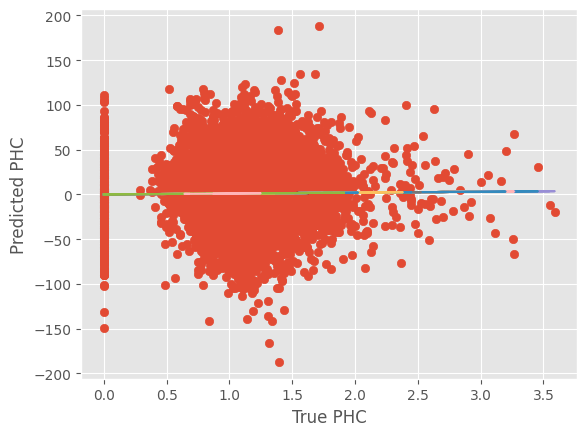

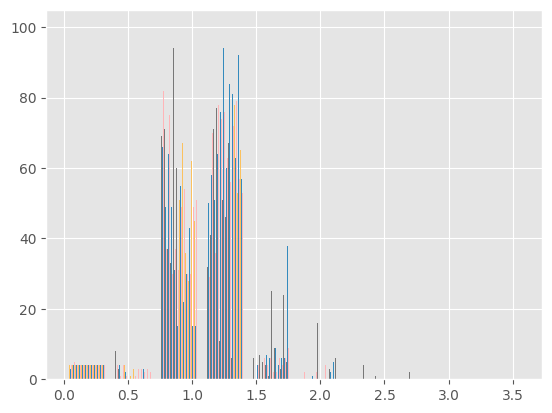

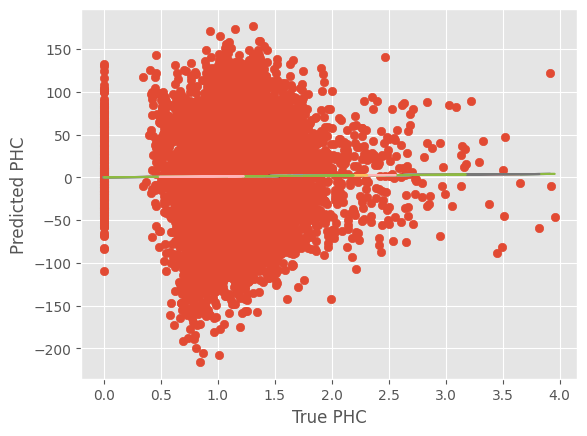

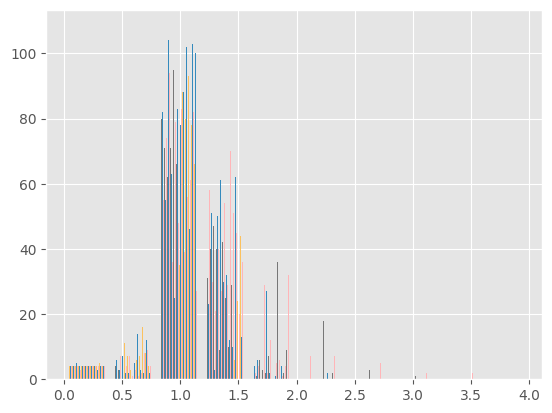

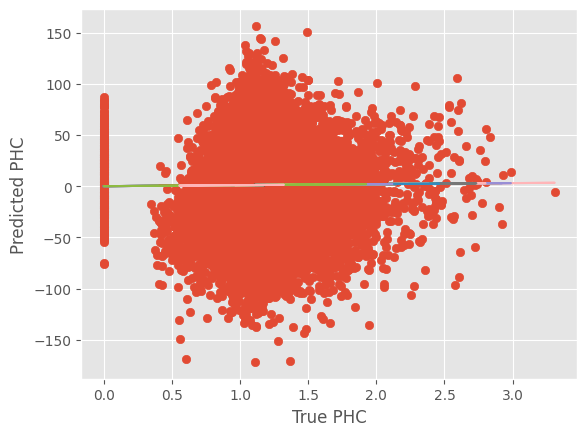

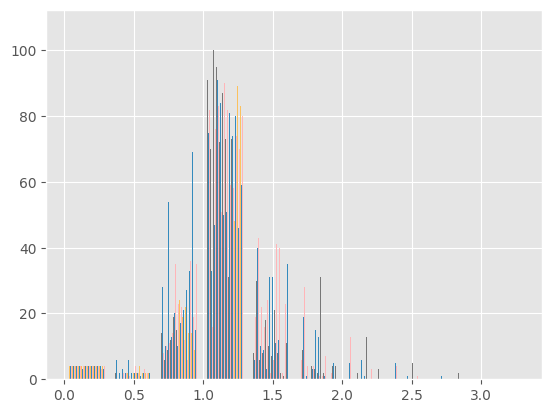

In [40]:
df = pd.read_excel(DataPath)
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size =119
  out_columns = df.columns.str.contains('_SUVR')
  feature_columns = df.columns.str.contains('_VOLUME')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[119])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(RMSE_NN)
print(R2)

SVM Implementation

In [41]:
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  out_columns = df.columns.str.contains('SUVR')
  feature_columns = df.columns.str.contains('_VOLUME')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(RMSE_SVM)
print(R2)

1.1047195459914323
-75.31449236148958
[1.10184513 1.12724364 1.08246635 1.08933502 1.12270759]
[-89.80051104 -62.63850713 -83.75248339 -68.74554864 -71.6354116 ]


### Single Input ROI Volume to SUVR Scores with PHC scores as additional Inputs (ROI Volume inputs with SUVR outputs)

Here developed a single input of an ROI Volume rather than a fully connected network that allows cross talk between different ROIs. This allows a one to one relationship with an ROI Volume and its corresponding SUVR score.

New Neural Net Classifier For a Single Input system

In [42]:
# Build a classifier in PyTorch
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size=None, nr_classes=1, hidden_layer_sizes=[16,8], save_path="models"):
        super().__init__()
        self.name = self.__class__.__name__ + '-'.join([str(n) for n in hidden_layer_sizes])
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Define the architecture of the model
        layers = []
        nr_neurons = [input_size] + hidden_layer_sizes
        for ix in range(len(nr_neurons)-1):
            # A linear, fully-connected layer
            layers.append(nn.Linear(nr_neurons[ix], nr_neurons[ix+1]))
            # A ReLU activation function
            layers.append(nn.ReLU())
        # Final layer, in this (nr_classes==1) classification
        layers.append(nn.Linear(nr_neurons[-1], nr_classes))
        # Finally, we place them one after the other
        self.layers = nn.Sequential(*layers)
        # The softmax function ensures we have one output per class, and these add up to 1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        '''Forward pass'''
        logits = self.layers(x)
        return logits

    def predict(self, X):
        '''Make a prediction based on a given input'''
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return int(pred.argmax().detach())

    def save(self, state_name='last', verbose=False):
        '''Saves a model state in the defined path, with the model name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        torch.save(self.state_dict(), os.path.join(self.save_path, model_state_name))
        if verbose:
            print("Saved PyTorch model state {} in {}".format(model_state_name, self.save_path))

    def restore(self, state_name):
        '''Restores a model state for the given state name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        self.load_state_dict(torch.load(os.path.join(self.save_path, model_state_name)))

In [43]:
from collections import Counter

# Adjust labels to start from 0

# Print label classes and counts
print(Counter(df['PTGENDER']))

Counter({2: 438, 1: 426})


In [44]:
print(df['age'].mean())

73.85413339417447


In [45]:
print(df['age'].max())

94.4394250513347


In [46]:
print(df['age'].min())

55.2772073921971


First a Pearson Correlation test to see if there is any significance in the correlation of the volume scores and the confounding variables of age and gender

In [47]:
print(stats.pearsonr(df['CTX_LH_PRECENTRAL_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.20565926414311791, pvalue=1.0493879204944676e-09)


In [48]:
print(stats.pearsonr(df['CTX_LH_PRECENTRAL_VOLUME'] , df['PTGENDER']))

PearsonRResult(statistic=-0.3230689035548924, pvalue=1.9375796349714244e-22)


In [49]:
print(stats.pearsonr(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'] , df['PTGENDER']))

PearsonRResult(statistic=-0.3990053240183068, pvalue=2.3542522303584707e-34)


In [50]:
print(stats.pearsonr(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.16396929275450722, pvalue=1.2626318692776486e-06)


In [51]:
print(stats.pearsonr(df['CTX_RH_TEMPORALPOLE_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.05631959614097619, pvalue=0.09805279358418464)


In [52]:
print(stats.pearsonr(df['CTX_RH_TEMPORALPOLE_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.05631959614097619, pvalue=0.09805279358418464)


In [53]:
print(stats.pearsonr(df['CTX_RH_MIDDLETEMPORAL_VOLUME'] , df['PTGENDER']))

PearsonRResult(statistic=-0.317270616701127, pvalue=1.1730624276306434e-21)


In [54]:
print(stats.pearsonr(df['CTX_RH_MIDDLETEMPORAL_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.22705286028804894, pvalue=1.4513217485712892e-11)


# PHC Memory Volume+PHC score to SUVR output

['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.49366968188967025
Epoch 5 loss 0.10280477686652116
Epoch 10 loss 0.029778219250563
Epoch 15 loss 0.018120175786316396
Epoch 20 loss 0.017782585096678565
Epoch 25 loss 0.0175352213322185
Epoch 30 loss 0.017717413323199642
Epoch 35 loss 0.01767119969174798
Epoch 40 loss 0.01753203166507384
Epoch 45 loss 0.01762568755740566
Epoch 50 loss 0.017577369371429084
Epoch 55 loss 0.018113931253485913
Epoch 60 loss 0.01760639508387872
Epoch 65 loss 0.017668577513125325
Epoch 70 loss 0.017711509308511657
Epoch 75 loss 0.01759700000651979
Epoch 80 loss 0.017547241202555595
Epoch 85 loss 0.017562559120623128
Epoch 90 loss 0.01776982014000948
Epoch 95 loss 0.017565354619624225
Finished training!
['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layers)

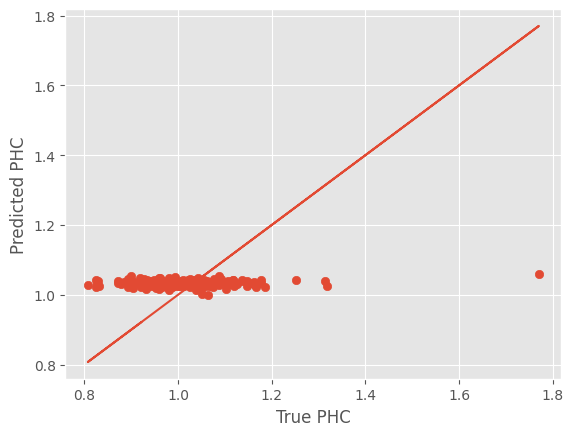

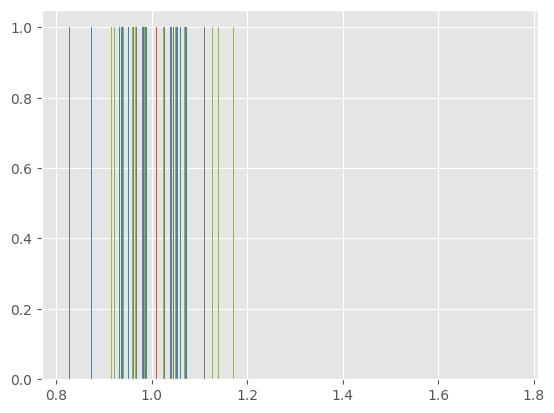

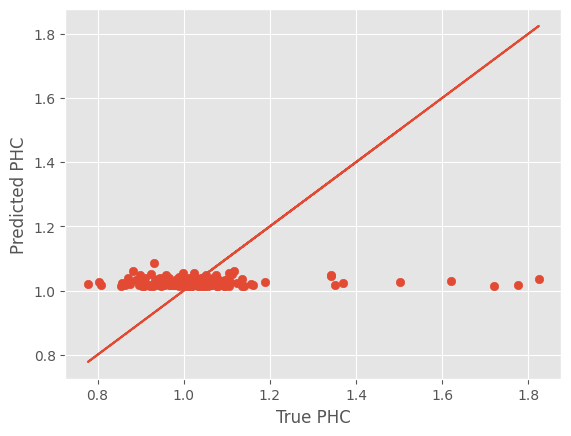

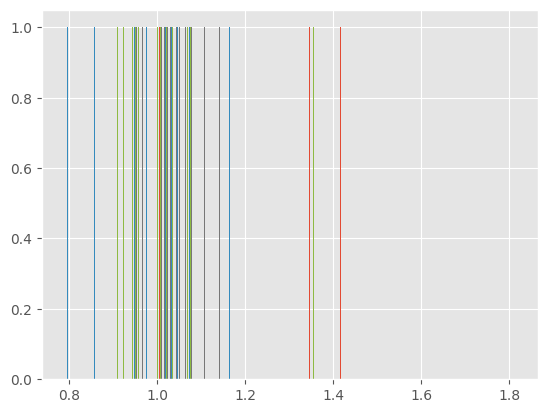

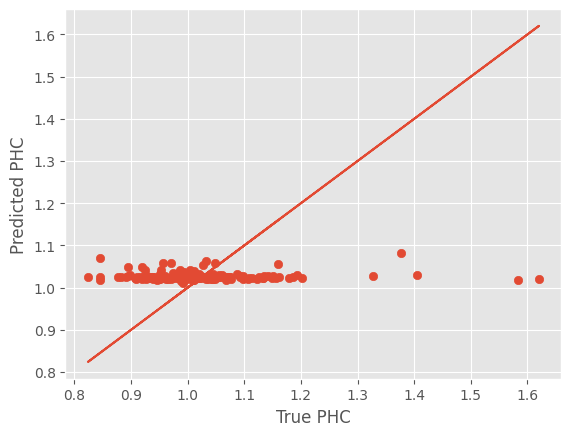

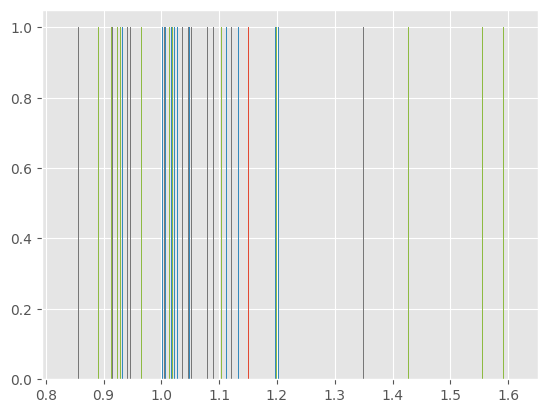

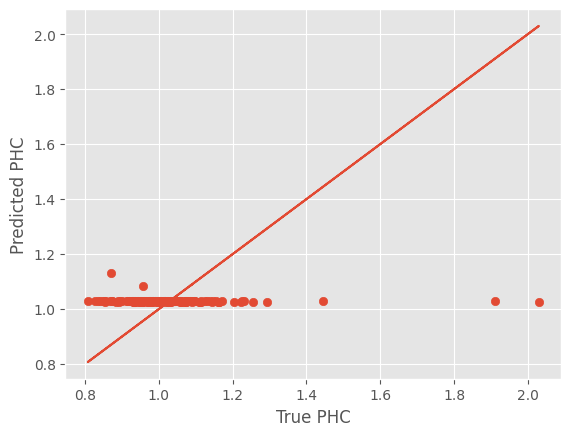

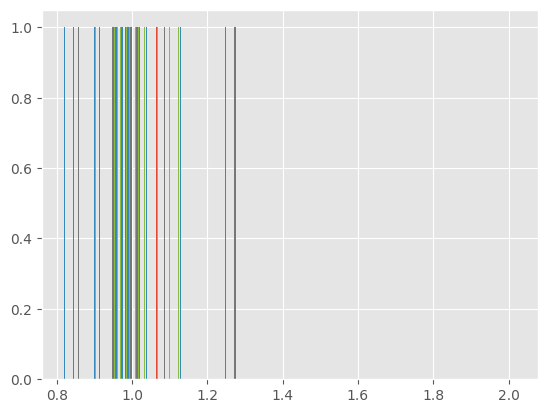

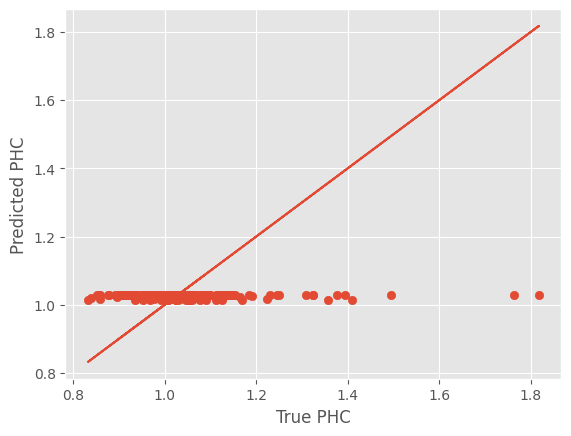

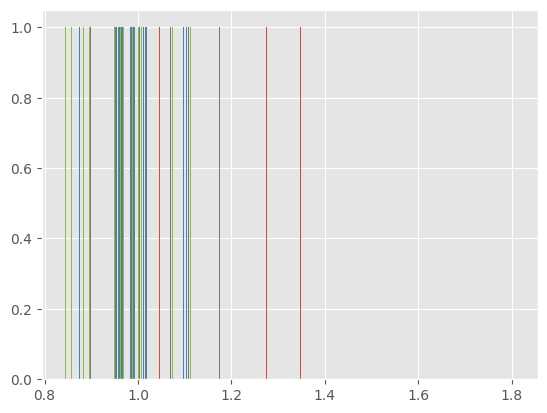

In [55]:
#PHC_MEM
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])
df['PHC_MEM_mannualJoin'] = stats.zscore(df['PHC_MEM_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME','PHC_MEM_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i] = eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC Memory Volume to SUVR output

['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.6533716934067862
Epoch 5 loss 0.1515953814876931
Epoch 10 loss 0.018279208106520985
Epoch 15 loss 0.0176567702088505
Epoch 20 loss 0.017597750451282732
Epoch 25 loss 0.01766408551151731
Epoch 30 loss 0.017606015144182103
Epoch 35 loss 0.017949261499701868
Epoch 40 loss 0.017651363843054112
Epoch 45 loss 0.01764802054967731
Epoch 50 loss 0.01759173199201801
Epoch 55 loss 0.017688502125175937
Epoch 60 loss 0.017624023698070753
Epoch 65 loss 0.017619363017313715
Epoch 70 loss 0.017605229438881258
Epoch 75 loss 0.01762730146292597
Epoch 80 loss 0.01773838508109163
Epoch 85 loss 0.017557739744162453
Epoch 90 loss 0.017738059154778187
Epoch 95 loss 0.017662495733903986
Finished training!
['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layer

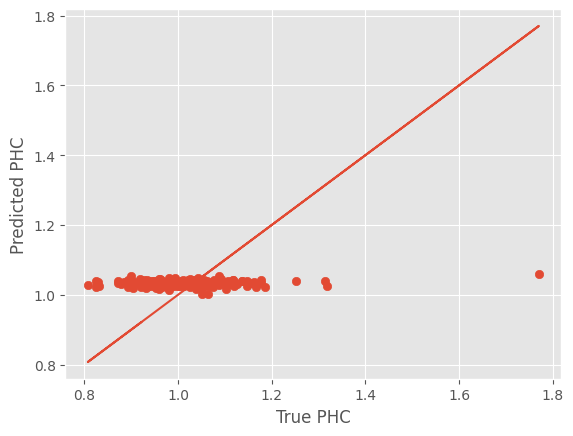

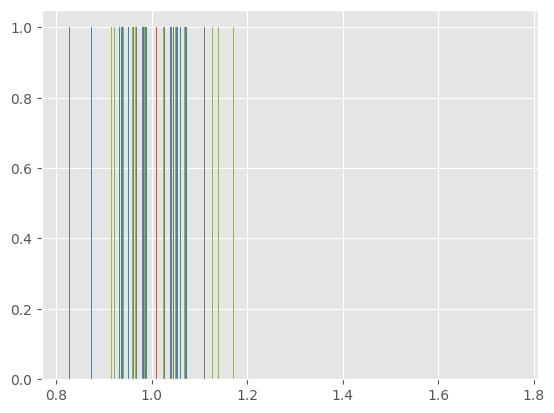

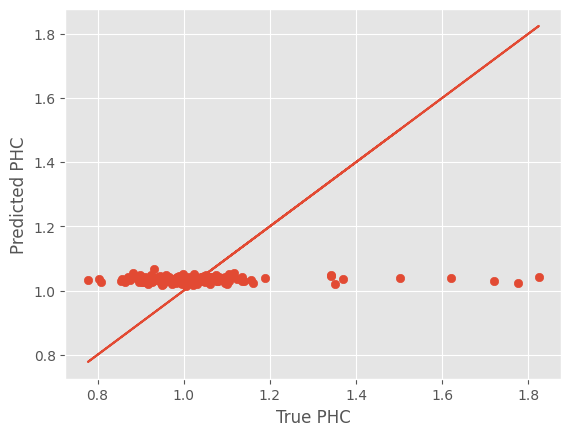

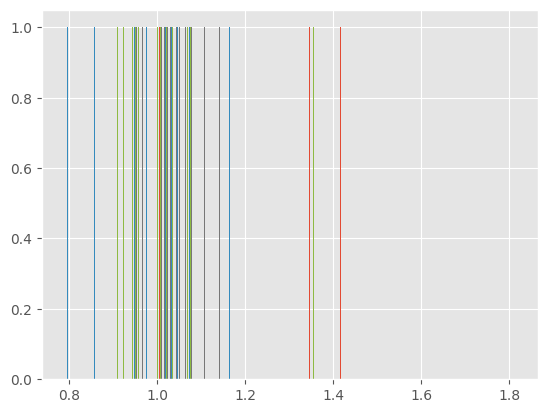

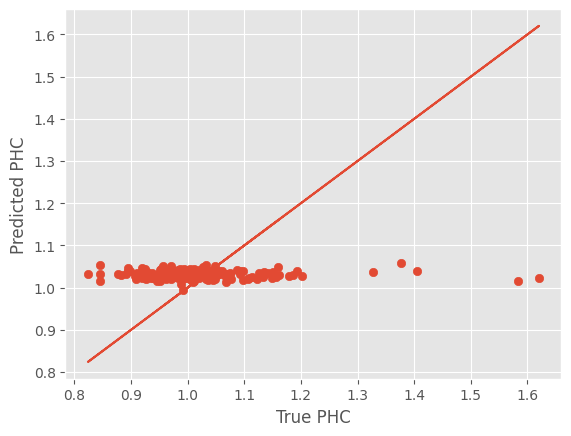

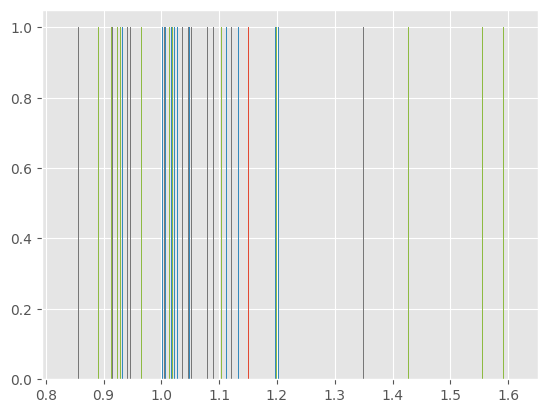

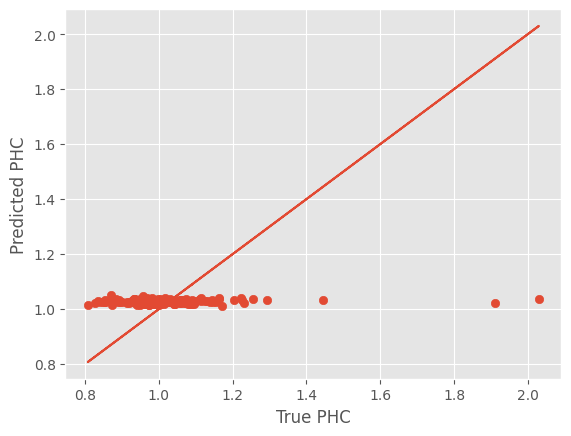

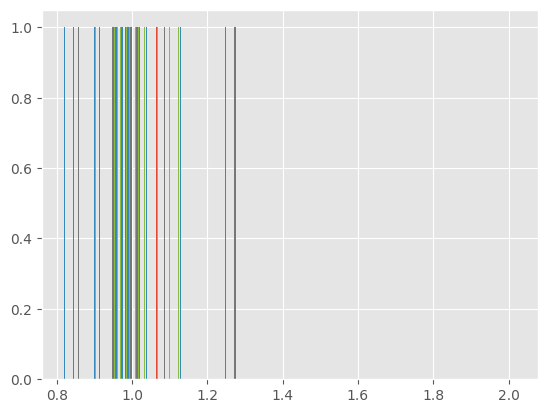

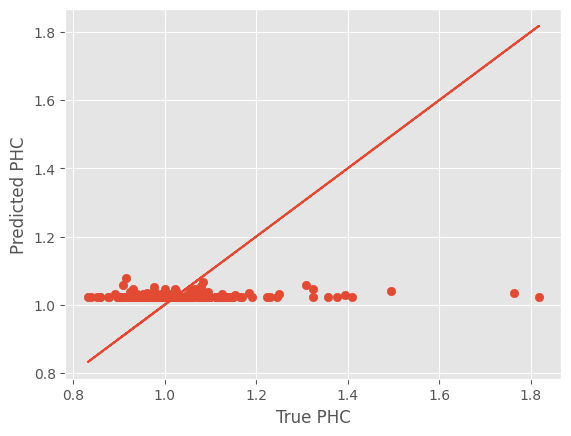

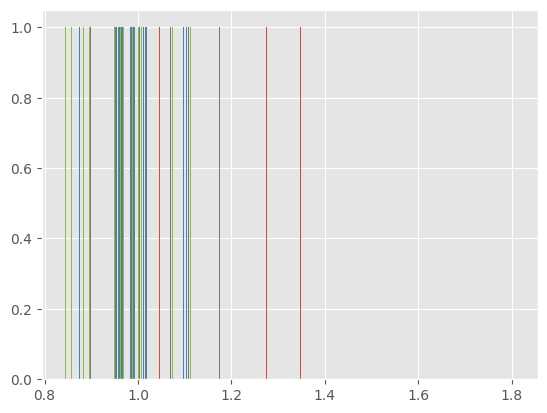

In [56]:
#PHC_MEM
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC EXF Volume+PHC score to SUVR output

['RIGHT_CEREBELLUM_CORTEX_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.4466355408940996
Epoch 5 loss 0.16914196056979044
Epoch 10 loss 0.0035893107165715526
Epoch 15 loss 0.0006577855887631553
Epoch 20 loss 0.0006482251273285198
Epoch 25 loss 0.0006480470118861246
Epoch 30 loss 0.0006545304266702649
Epoch 35 loss 0.0006618649962287496
Epoch 40 loss 0.0006495313572356411
Epoch 45 loss 0.0006466827718148644
Epoch 50 loss 0.0006481239395465569
Epoch 55 loss 0.0006514194920392973
Epoch 60 loss 0.0006515541104558256
Epoch 65 loss 0.0006466805753007066
Epoch 70 loss 0.0006545412807359494
Epoch 75 loss 0.0006642841810909366
Epoch 80 loss 0.0006572317837188685
Epoch 85 loss 0.0006618057063730833
Epoch 90 loss 0.0006683855003627417
Epoch 95 loss 0.000661051737967812
Finished training!
['RIGHT_CEREBELLUM_CORTEX

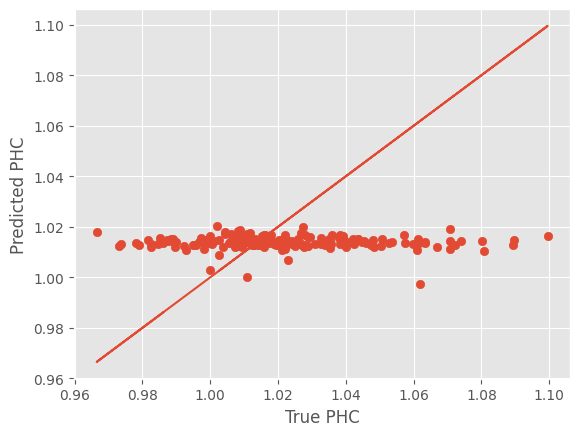

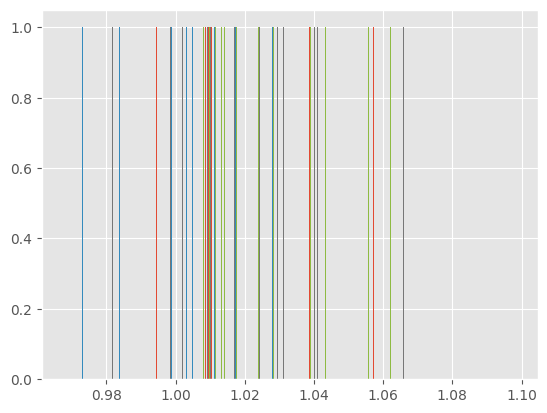

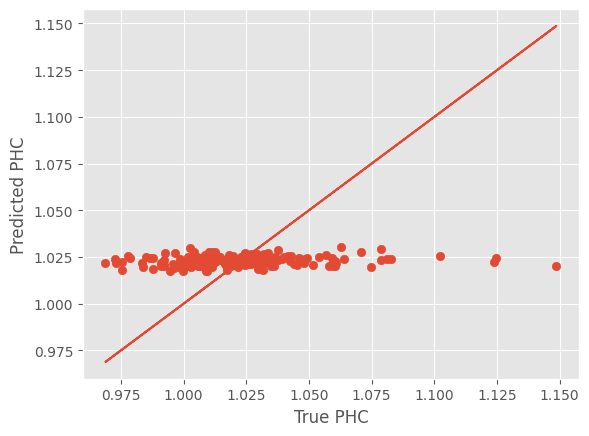

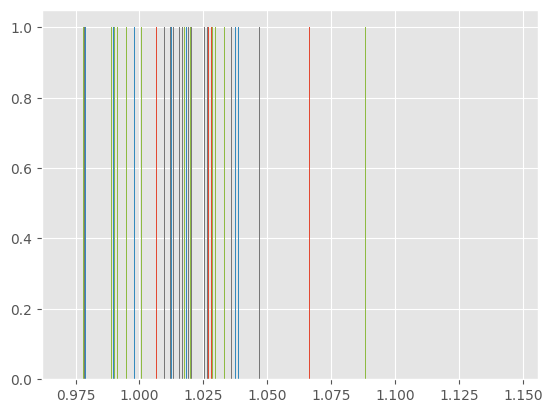

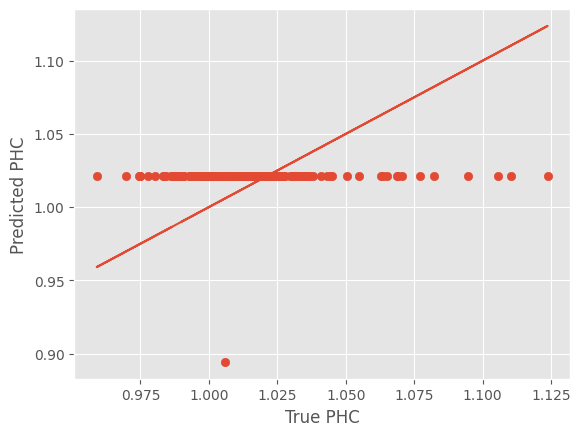

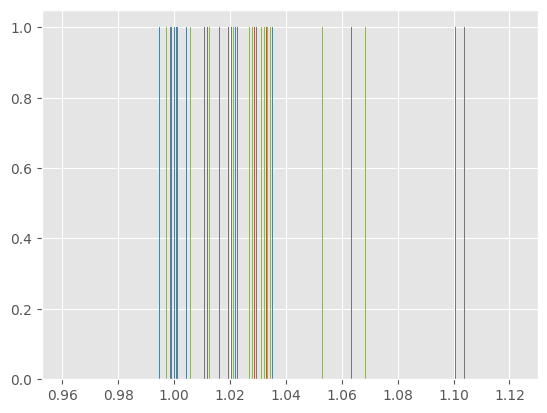

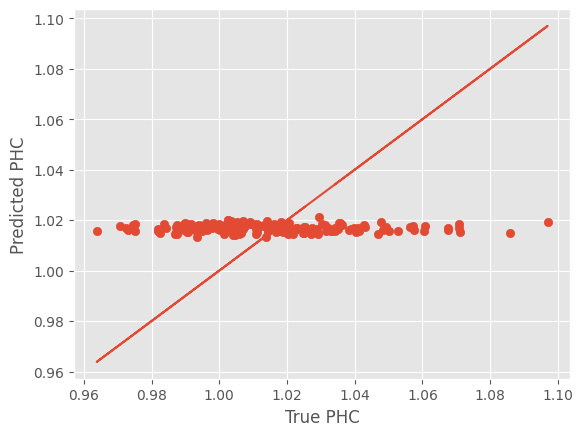

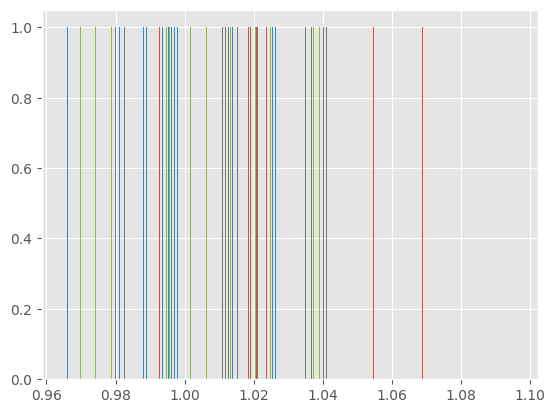

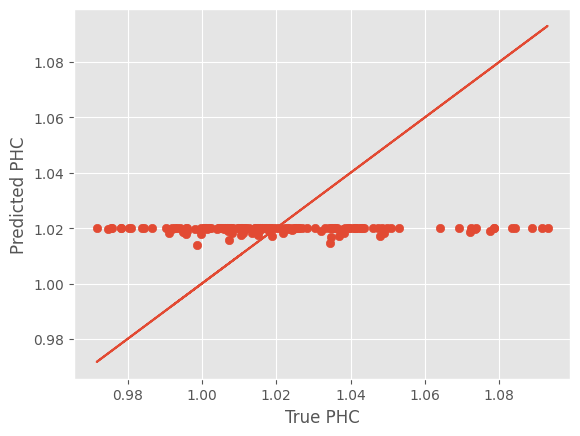

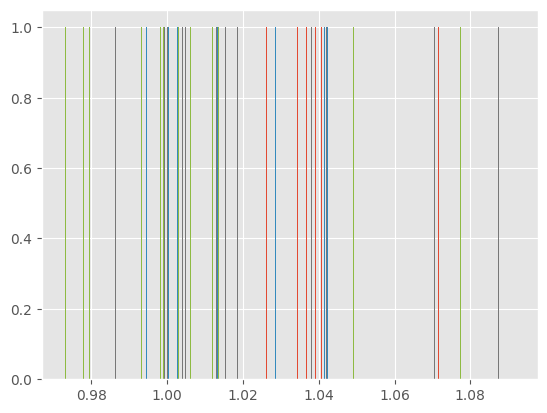

In [57]:
#PHC_EXF
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])
df['PHC_EXF_mannualJoin'] = stats.zscore(df['PHC_EXF_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME','PHC_EXF_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC EXF Volume to SUVR output

['RIGHT_CEREBELLUM_CORTEX_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.9056170327322823
Epoch 5 loss 0.11758490659828696
Epoch 10 loss 0.003096956992521882
Epoch 15 loss 0.0006581003526142532
Epoch 20 loss 0.0006462831966928207
Epoch 25 loss 0.0006460951564284707
Epoch 30 loss 0.0006451862910970314
Epoch 35 loss 0.000644661245210695
Epoch 40 loss 0.0006504034089240511
Epoch 45 loss 0.0006532192026497796
Epoch 50 loss 0.0006508934627553182
Epoch 55 loss 0.0006495240005148974
Epoch 60 loss 0.0006564254273793527
Epoch 65 loss 0.0006531241183568324
Epoch 70 loss 0.0006495747062477416
Epoch 75 loss 0.0006524952448671683
Epoch 80 loss 0.0006596308263916789
Epoch 85 loss 0.0006530802993698412
Epoch 90 loss 0.0006571438981544426
Epoch 95 loss 0.0006615372208346213
Finished training!
['RIGHT_CEREBELLUM_CORTEX_

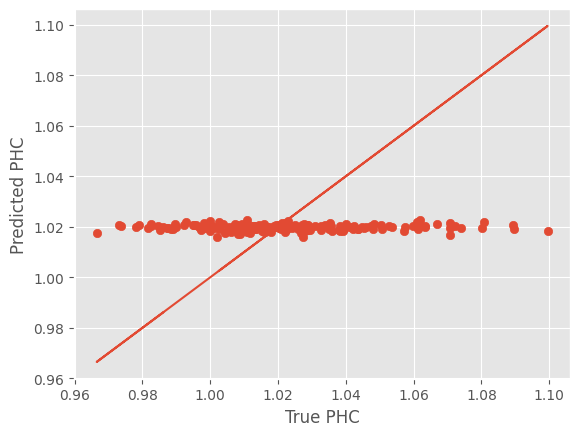

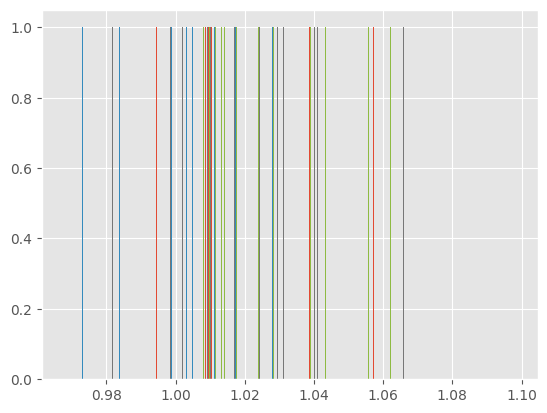

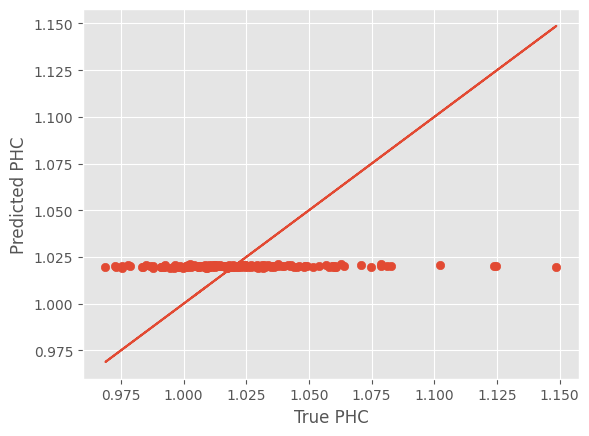

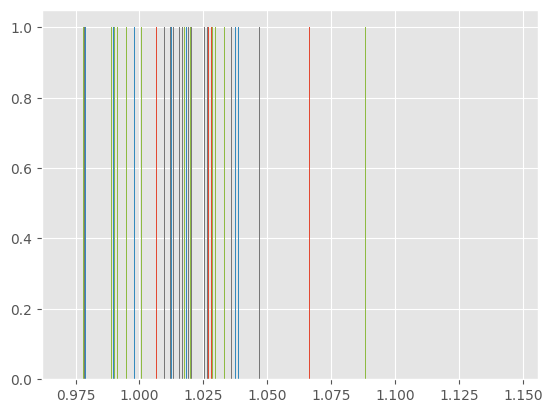

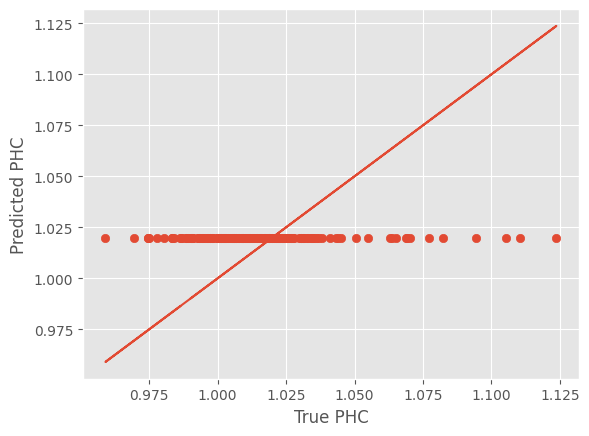

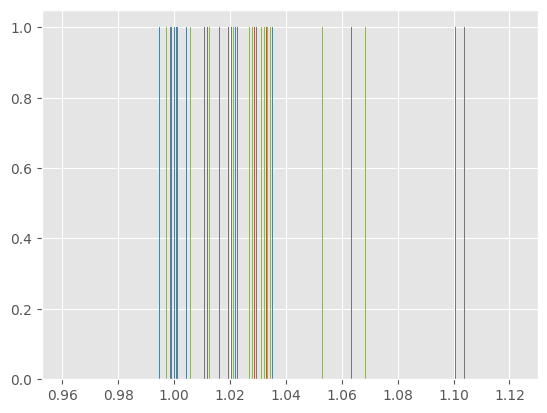

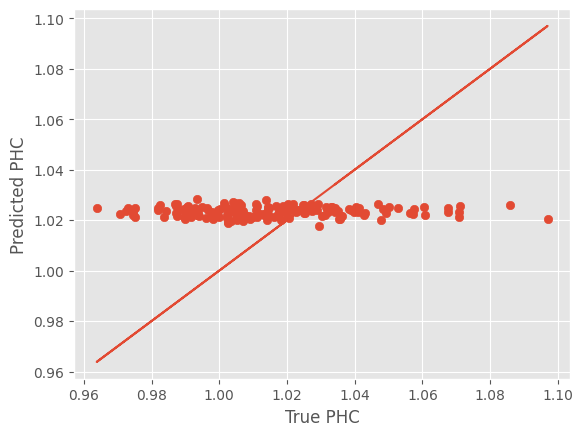

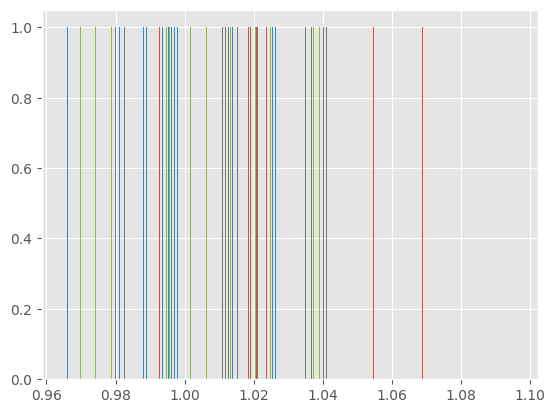

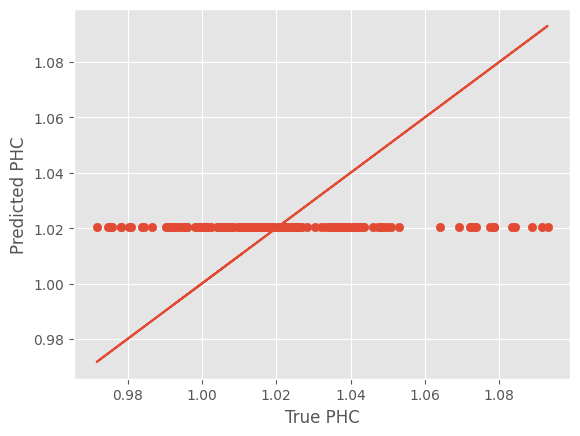

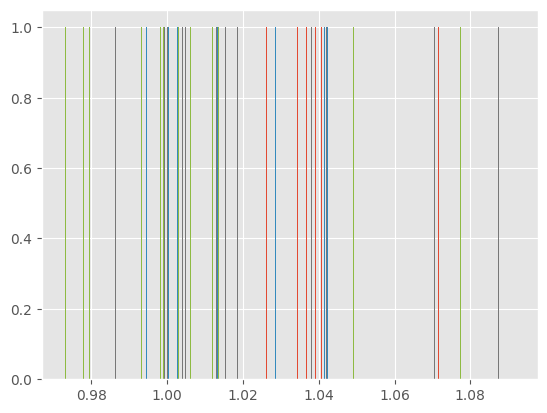

In [58]:
#PHC_EXF
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC LAN Volume+PHC score to SUVR output

['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 2.910182421548026
Epoch 5 loss 1.2963932148047856
Epoch 10 loss 0.6764049849339894
Epoch 15 loss 0.3613568689141955
Epoch 20 loss 0.20847323281424388
Epoch 25 loss 0.1331458908904876
Epoch 30 loss 0.10203397938166744
Epoch 35 loss 0.09152898544312588
Epoch 40 loss 0.08887040337680706
Epoch 45 loss 0.0883443422482482
Epoch 50 loss 0.0882127029588446
Epoch 55 loss 0.08863938716905458
Epoch 60 loss 0.08834399978763291
Epoch 65 loss 0.08826823169365525
Epoch 70 loss 0.08875135544554463
Epoch 75 loss 0.0882825124077499
Epoch 80 loss 0.09077962533171688
Epoch 85 loss 0.08826293874798076
Epoch 90 loss 0.08859896189533174
Epoch 95 loss 0.08855800610035658
Finished training!
['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequen

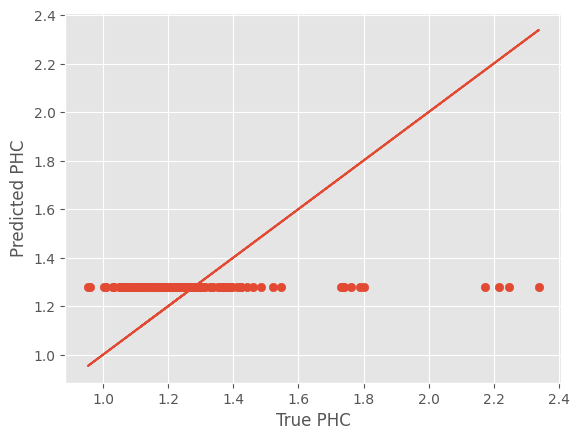

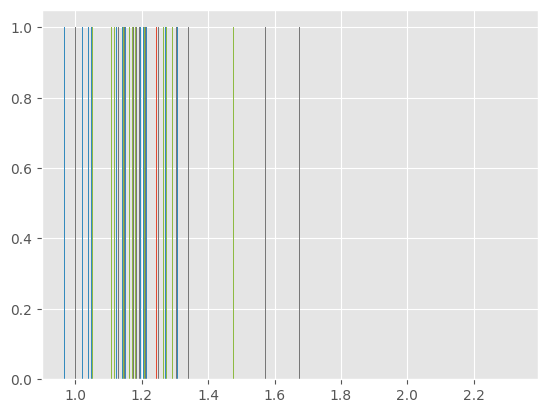

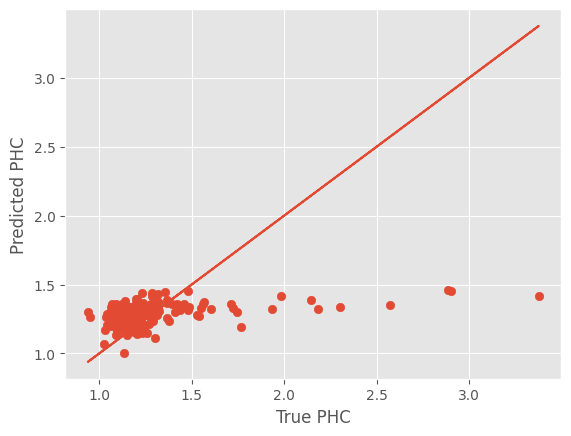

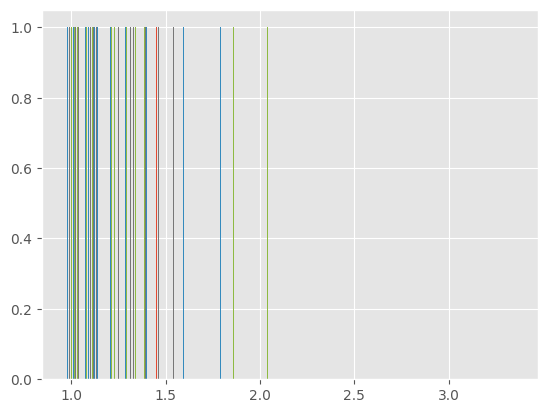

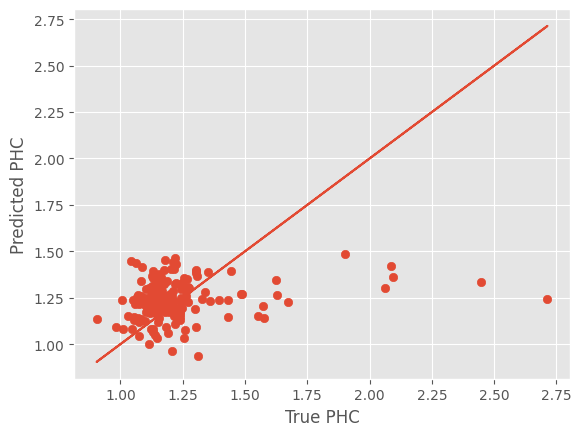

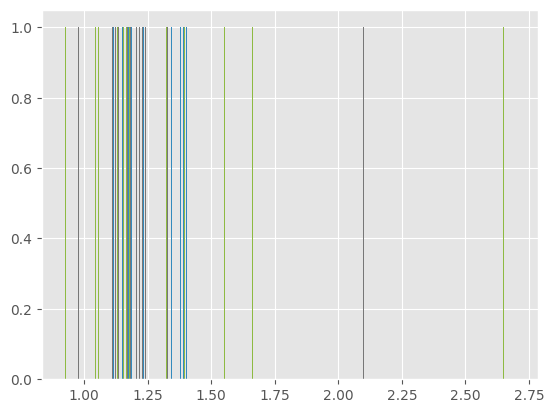

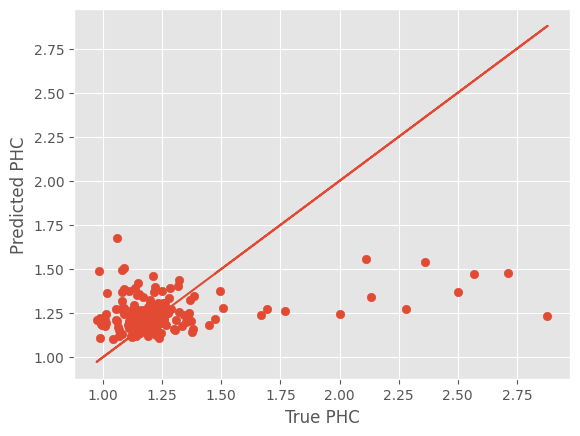

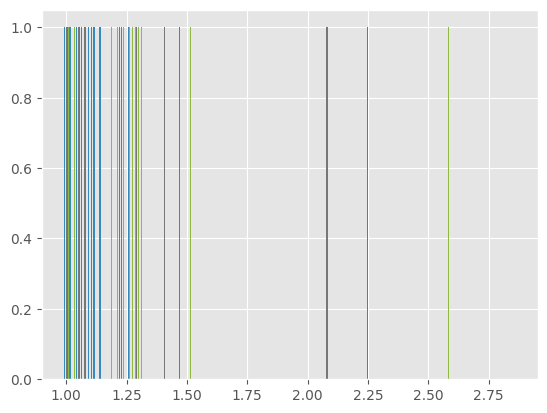

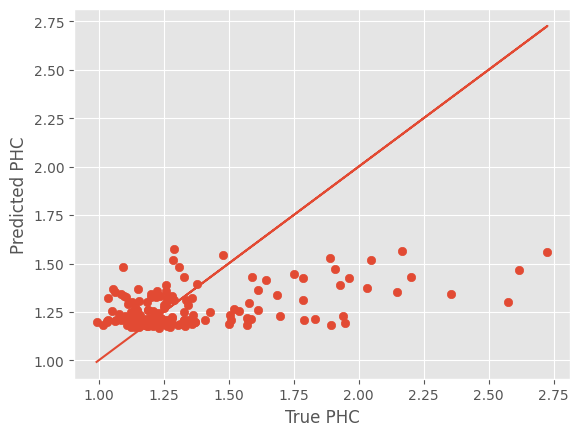

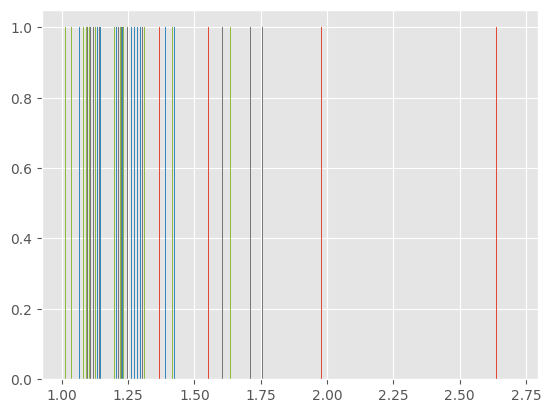

In [59]:
#PHC_LAN
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])
df['PHC_LAN_mannualJoin'] = stats.zscore(df['PHC_LAN_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME','PHC_LAN_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC LAN Volume to SUVR output

['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 4.085186856133597
Epoch 5 loss 1.9523088455200195
Epoch 10 loss 0.4260947719216347
Epoch 15 loss 0.09337033463775048
Epoch 20 loss 0.078704958934603
Epoch 25 loss 0.07850247865010584
Epoch 30 loss 0.0784744649327227
Epoch 35 loss 0.0786609458204891
Epoch 40 loss 0.07843631940361645
Epoch 45 loss 0.07838637623935937
Epoch 50 loss 0.07850625520305975
Epoch 55 loss 0.0784171102102846
Epoch 60 loss 0.08122770940618855
Epoch 65 loss 0.0785940249849643
Epoch 70 loss 0.07851120691214289
Epoch 75 loss 0.07867321925503867
Epoch 80 loss 0.0785834732465446
Epoch 85 loss 0.07873044091143779
Epoch 90 loss 0.07850335432615663
Epoch 95 loss 0.07948421142729266
Finished training!
['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequenti

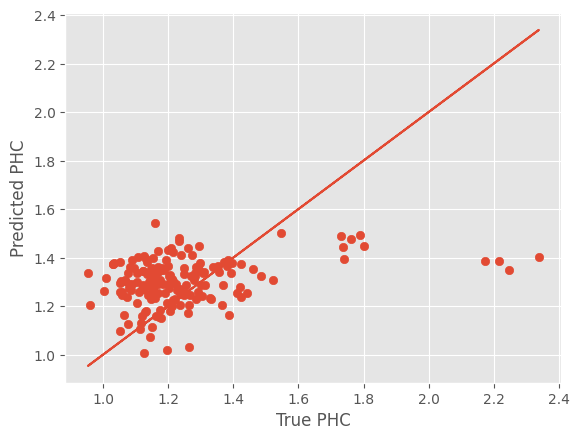

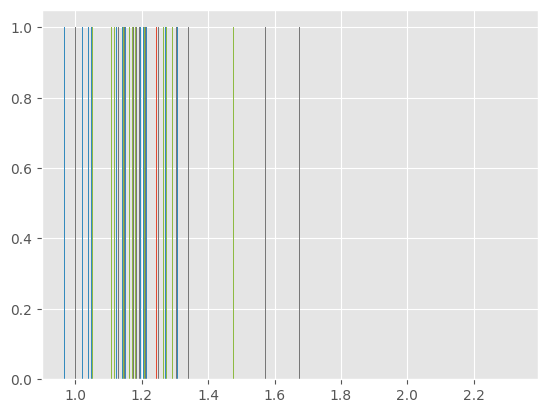

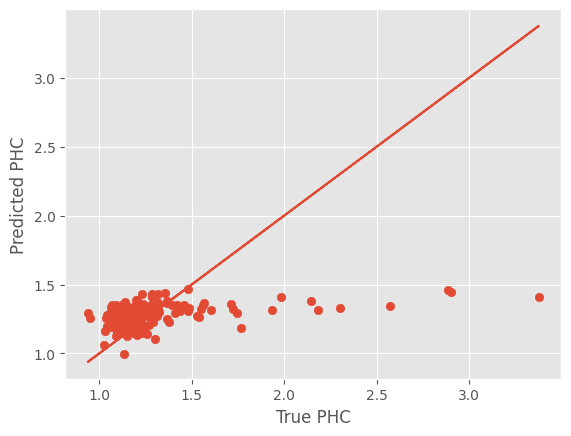

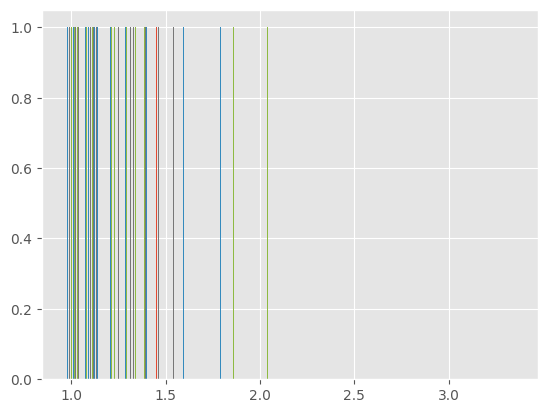

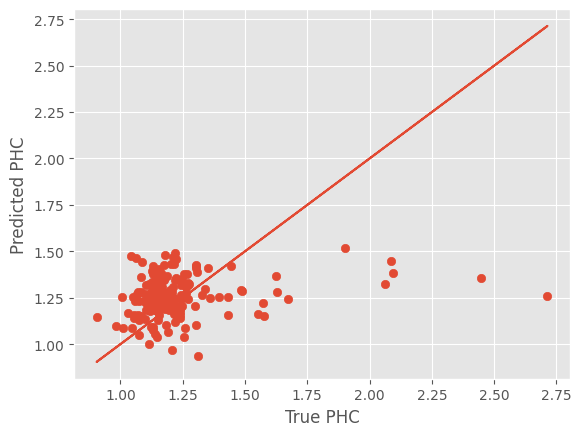

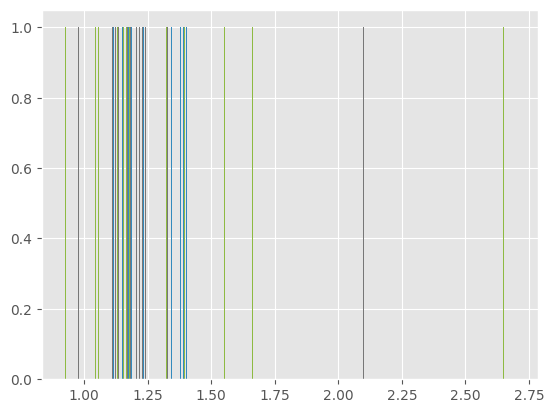

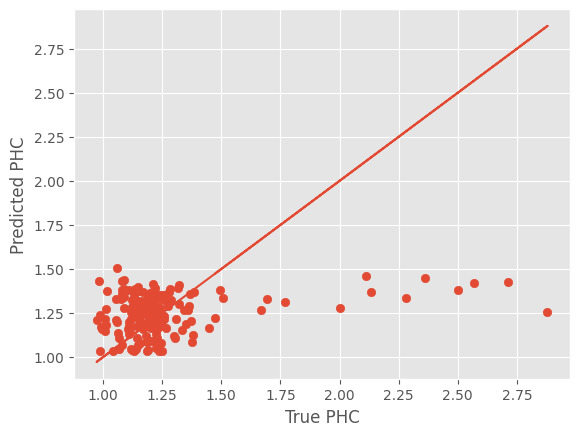

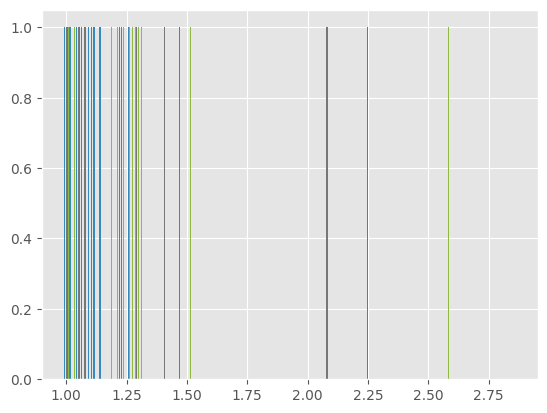

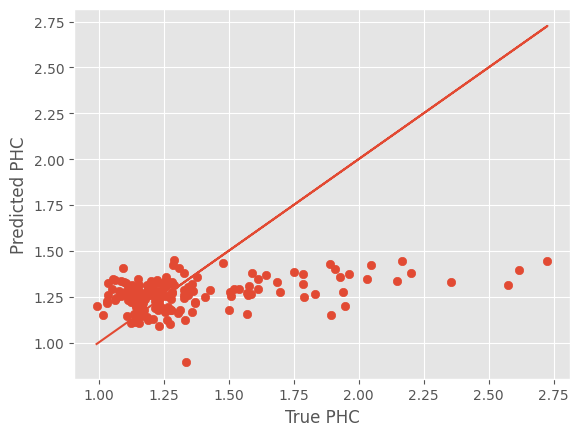

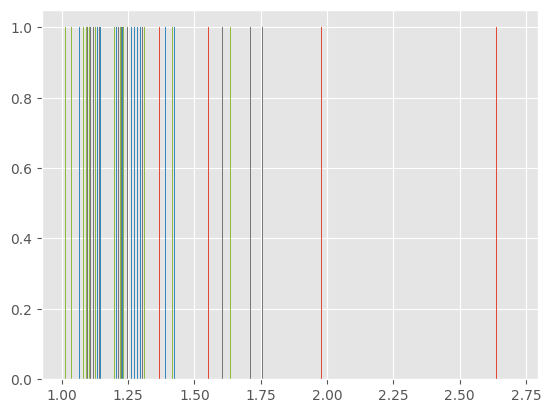

In [60]:
#PHC_LAN
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC VSP Volume+PHC score to SUVR output

['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.638255831173488
Epoch 5 loss 0.2932955128805978
Epoch 10 loss 0.0518576577704932
Epoch 15 loss 0.04270592707076243
Epoch 20 loss 0.04012358533218503
Epoch 25 loss 0.038855126589935805
Epoch 30 loss 0.03923202868817108
Epoch 35 loss 0.0382602385977017
Epoch 40 loss 0.03810664548405579
Epoch 45 loss 0.04036139897736055
Epoch 50 loss 0.037834866857987696
Epoch 55 loss 0.03796575785215412
Epoch 60 loss 0.0381086902692914
Epoch 65 loss 0.0380370307713747
Epoch 70 loss 0.03862533236055502
Epoch 75 loss 0.03812966146506369
Epoch 80 loss 0.03783866948714214
Epoch 85 loss 0.03766170117638207
Epoch 90 loss 0.03776529292309923
Epoch 95 loss 0.03787109402141401
Finished training!
['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequen

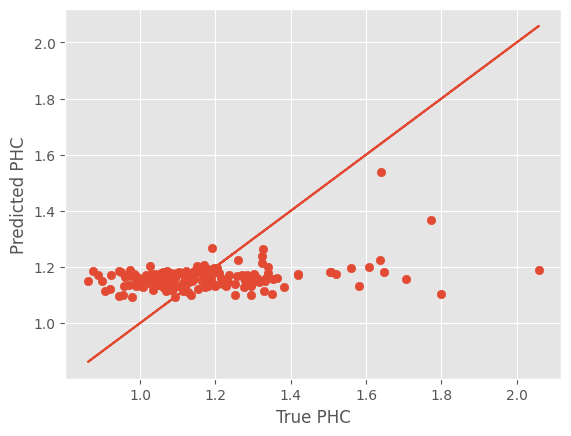

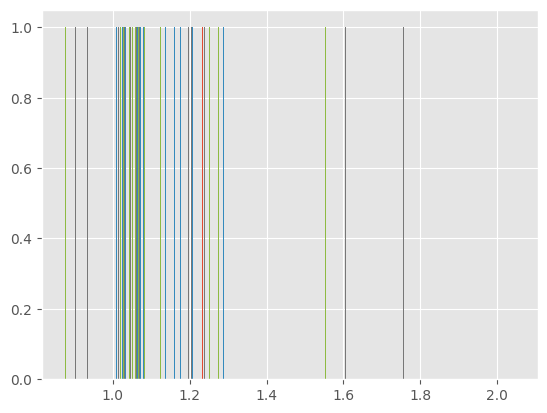

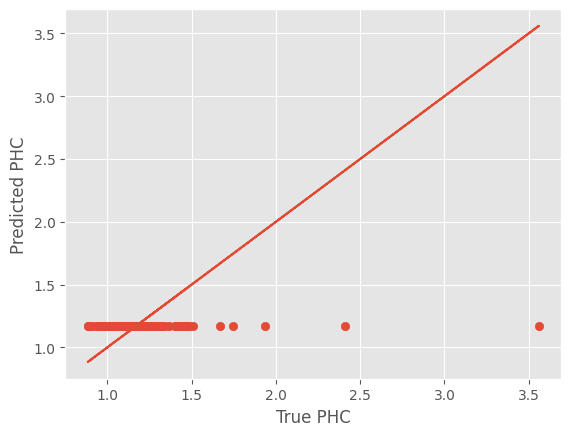

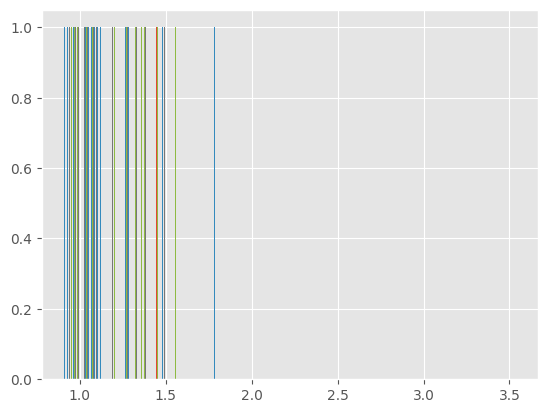

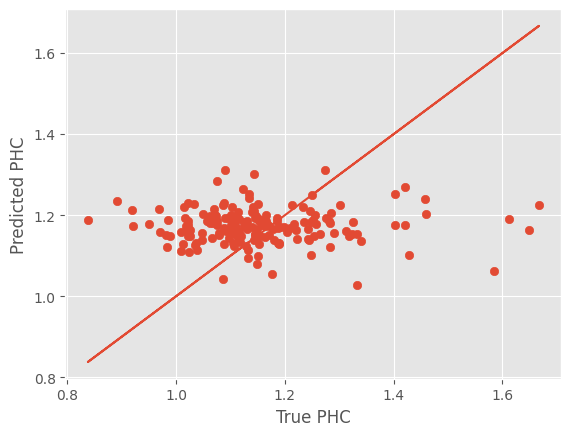

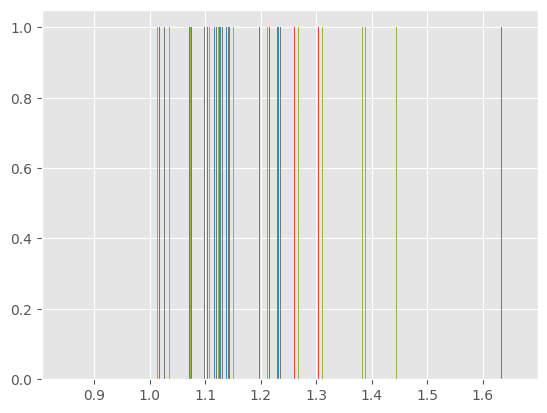

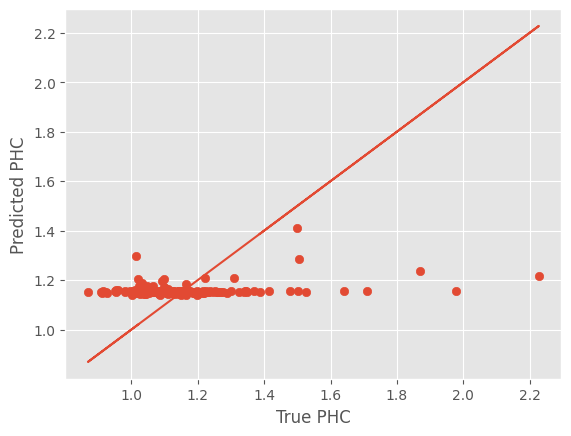

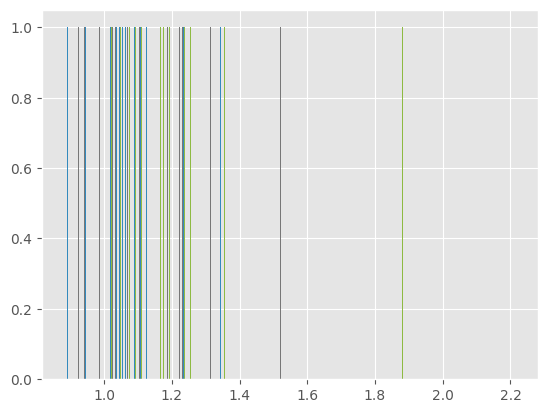

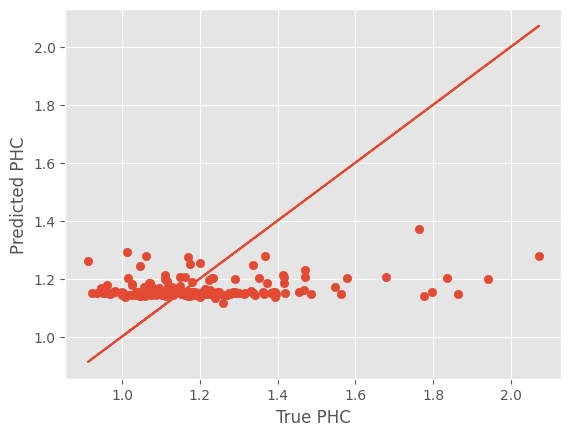

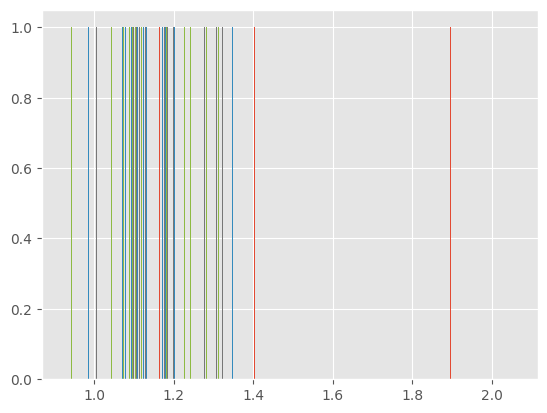

In [61]:
#PHC_VSP
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME','PHC_VSP_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC VSP Volume to SUVR output

['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.2118106646197182
Epoch 5 loss 0.6244429217917579
Epoch 10 loss 0.2944538086652756
Epoch 15 loss 0.13117624026324068
Epoch 20 loss 0.06569885334798269
Epoch 25 loss 0.045530454761215616
Epoch 30 loss 0.040096565904760996
Epoch 35 loss 0.03965212819665404
Epoch 40 loss 0.03935698055928307
Epoch 45 loss 0.0391427038137668
Epoch 50 loss 0.039190728962421414
Epoch 55 loss 0.03896910554197218
Epoch 60 loss 0.03929532299350415
Epoch 65 loss 0.039266109519771164
Epoch 70 loss 0.03899660856030615
Epoch 75 loss 0.03931271161085793
Epoch 80 loss 0.03897854008745136
Epoch 85 loss 0.03904559749311635
Epoch 90 loss 0.03916136170072215
Epoch 95 loss 0.0390096756829215
Finished training!
['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Se

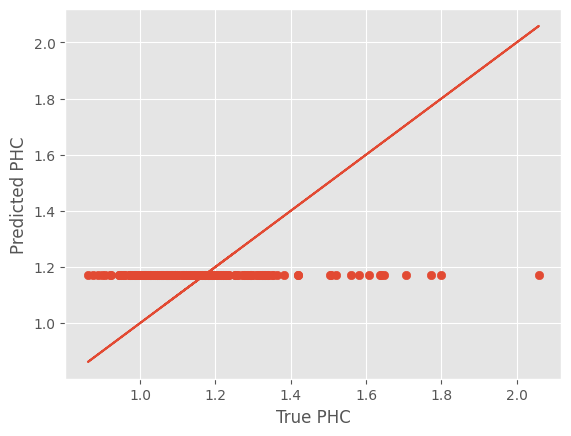

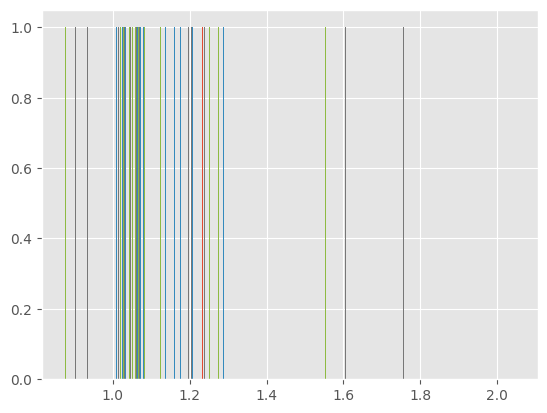

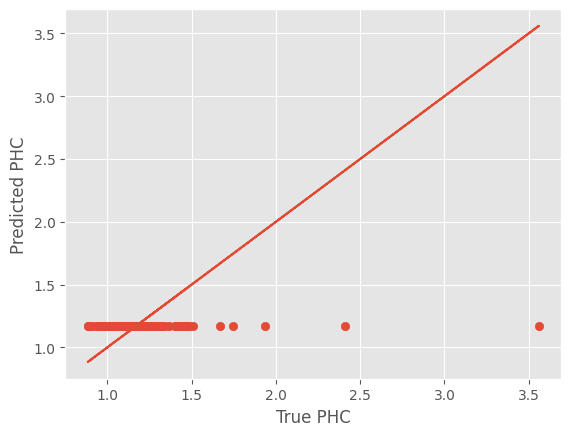

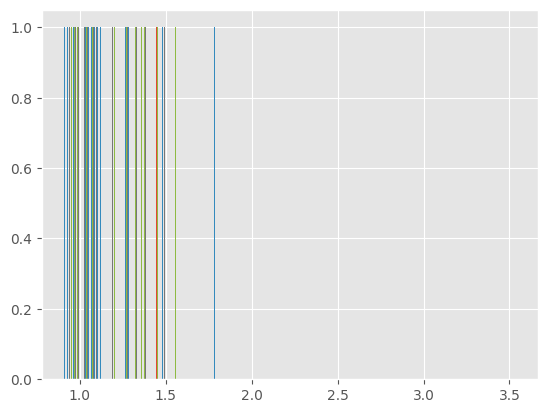

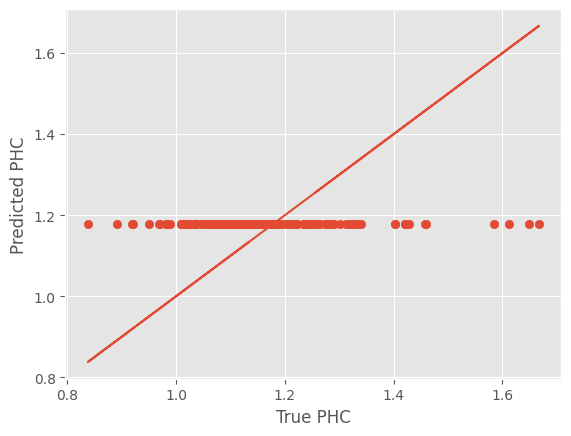

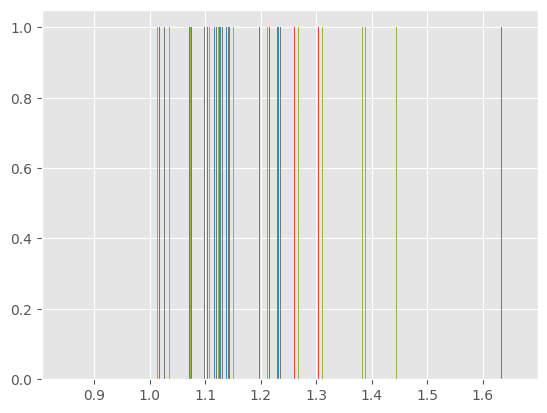

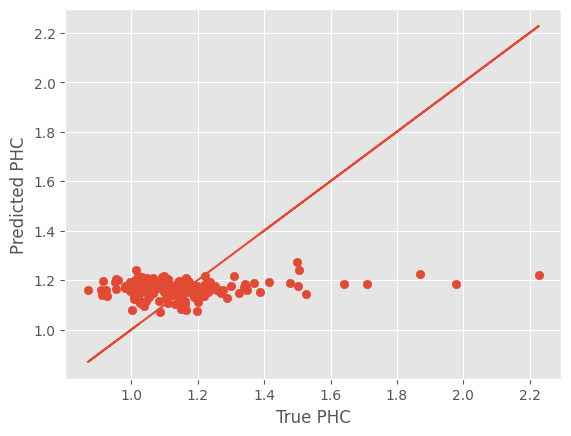

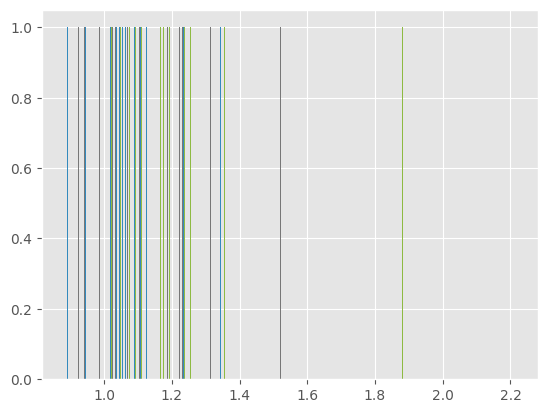

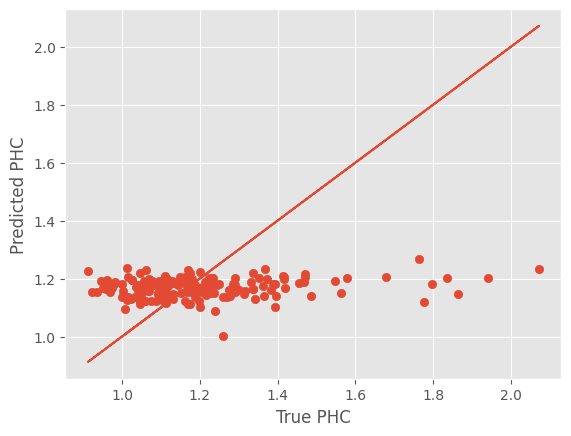

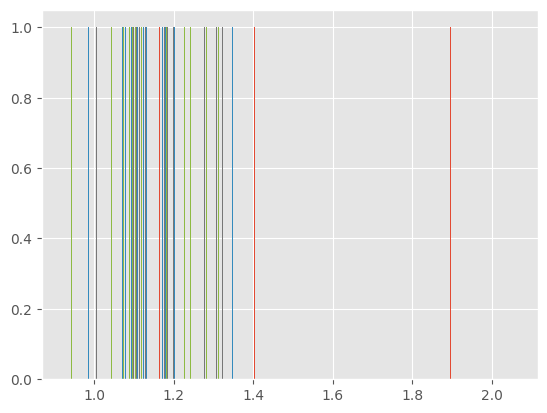

In [62]:
#PHC_VSP
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  test_ds = df.drop(train_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# SVMs

## PHC Memory Volume+PHC score to SUVR output

0.12892221739780585
-0.04699901491759495
[-0.18863301  0.00374062 -0.02758111 -0.00499779 -0.01752379]
[0.11279102 0.14569256 0.10752152 0.13880567 0.13980031]


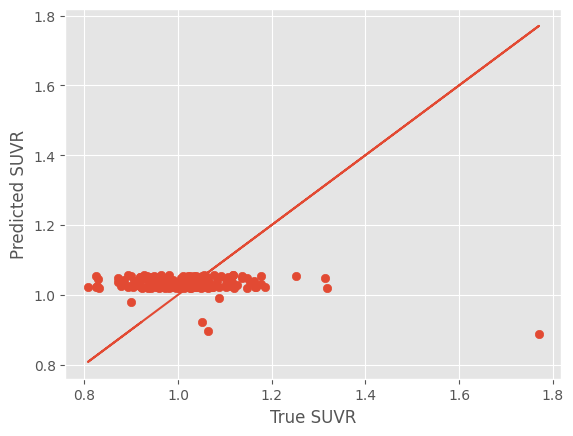

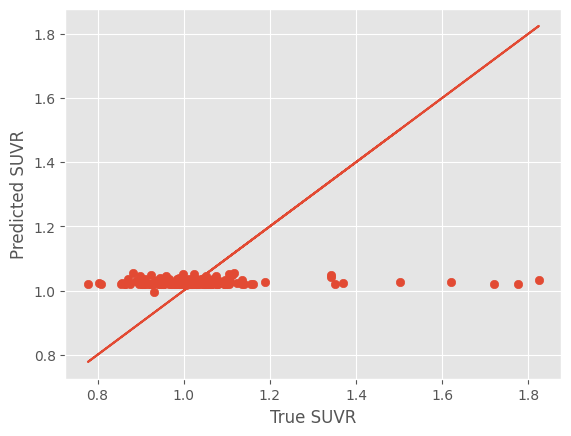

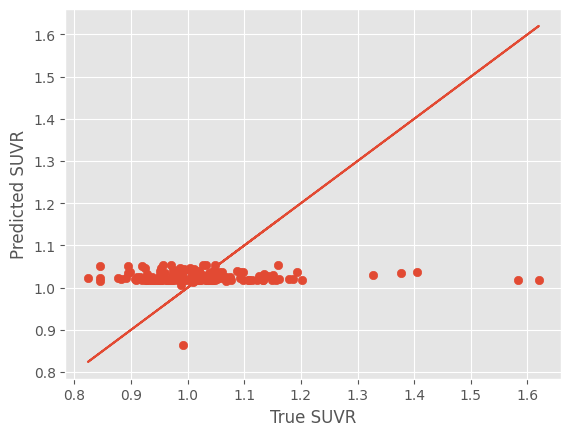

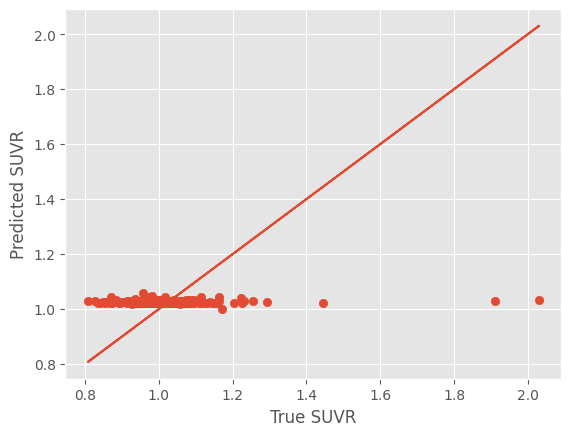

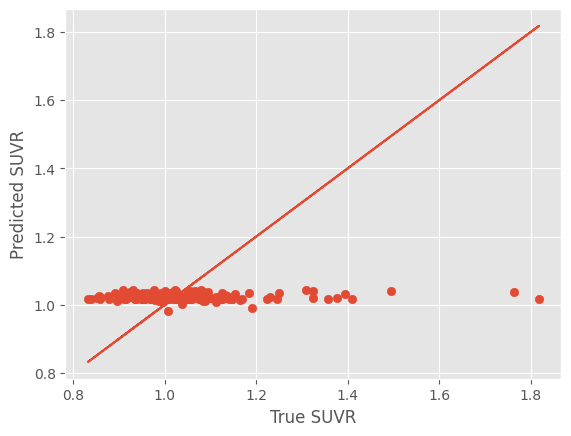

In [63]:
#PHC MEM
RMSE_SVM = np.zeros(5)
R2= np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])
df['PHC_MEM_mannualJoin'] = stats.zscore(df['PHC_MEM_mannualJoin'])
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME','PHC_MEM_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

## PHC EXF Volume+PHC score to SUVR output

0.04500032969095405
-2.1161552831922785
[-1.91012726 -1.32617439 -2.53052414 -2.1823521  -2.63159852]
[0.04357685 0.03794029 0.0481291  0.04625112 0.04910429]


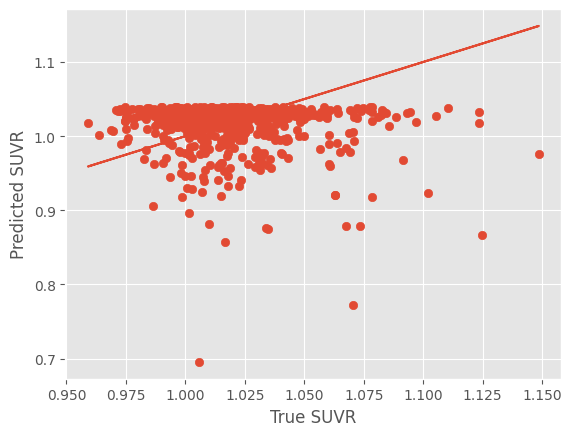

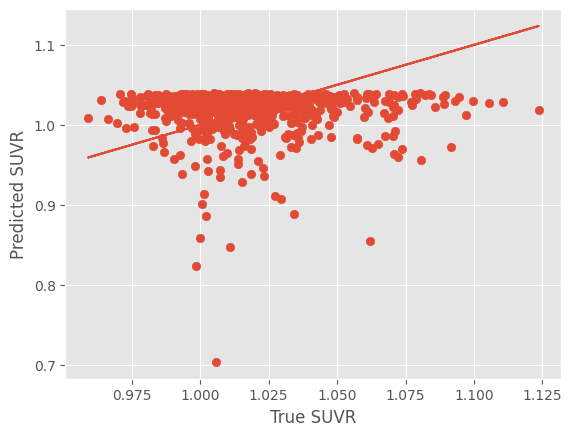

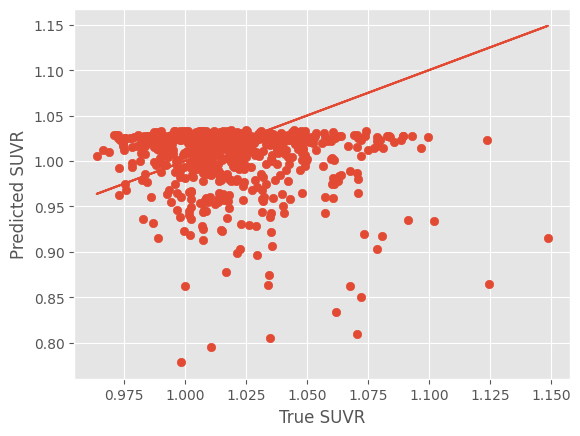

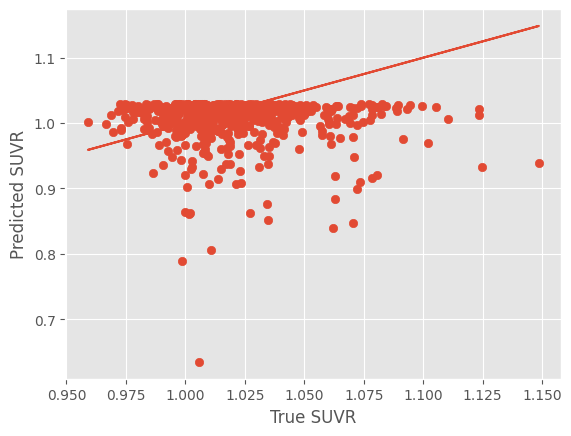

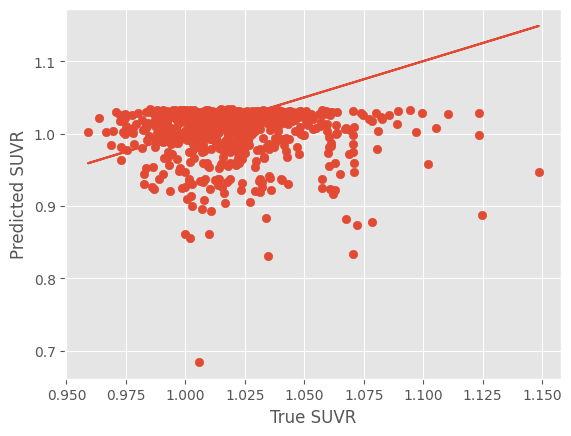

In [64]:
#PHC EXF
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])
for i in range(5):
  if i==0:
    train_ds = df.iloc[(0):(+172)]
  train_ds = df.iloc[((i*172)):((i*172)+172)]
  test_ds = df.drop(train_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME','PHC_EXF_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

## PHC LAN Volume+PHC score to SUVR output

0.2511183284998083
0.1635552693946631
[0.03604144 0.33169477 0.06185631 0.25235602 0.1358278 ]
[0.21081649 0.27064818 0.2203942  0.2587176  0.29501516]


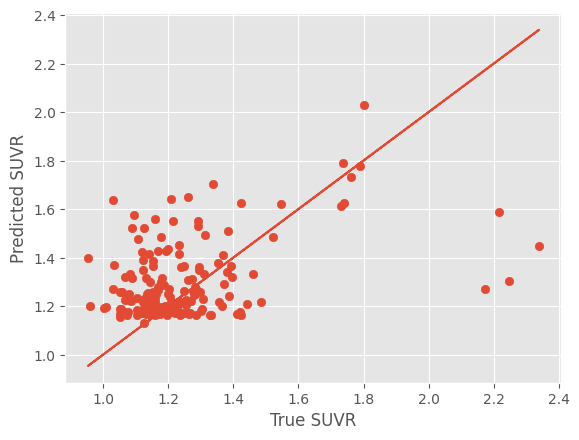

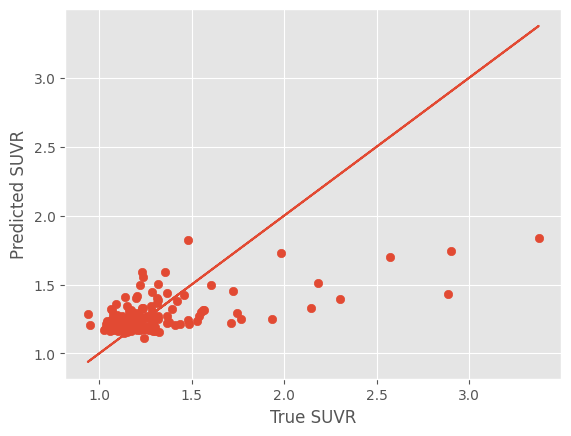

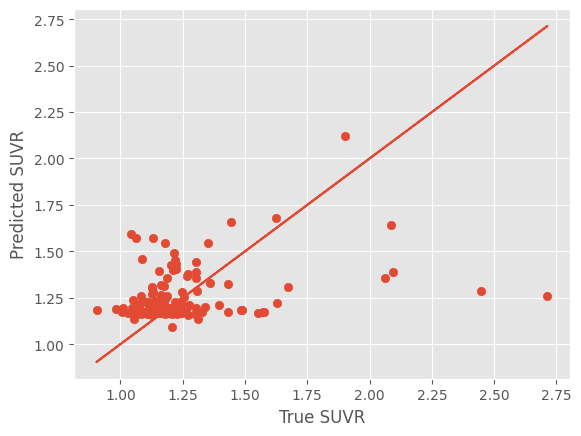

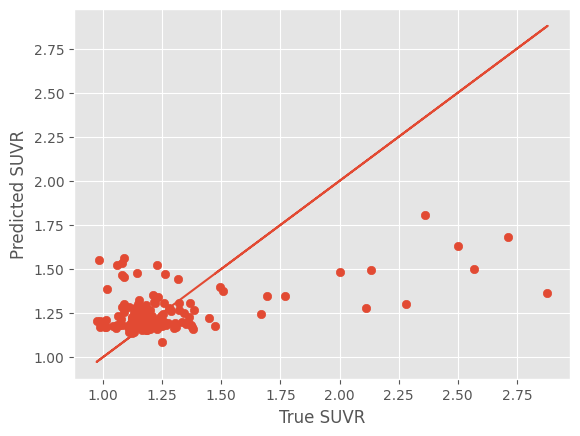

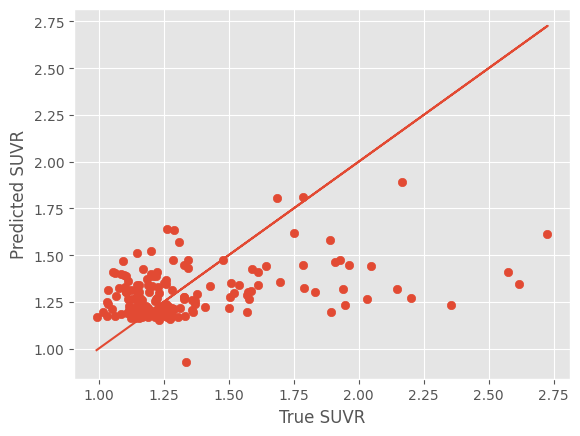

In [65]:
#PHC LAN
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME','PHC_LAN_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

## PHC VSP Volume+PHC score to SUVR output

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.1888958798011506
0.01257478108588701
[ 0.09927084  0.06916073 -0.14263933  0.04665194 -0.00957028]
[0.17943932 0.24938776 0.14118763 0.17451567 0.19994902]


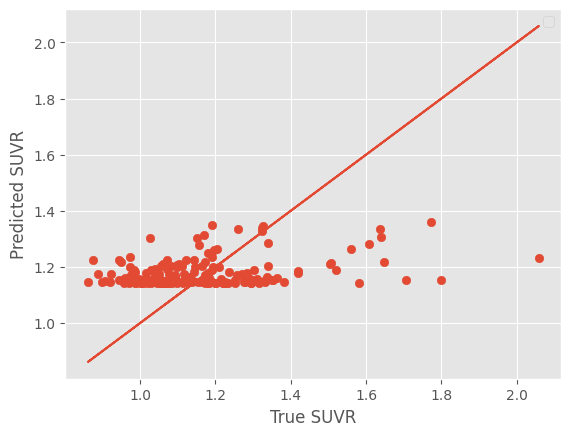

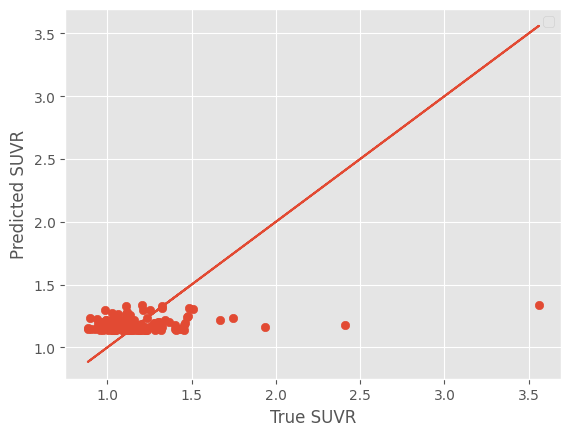

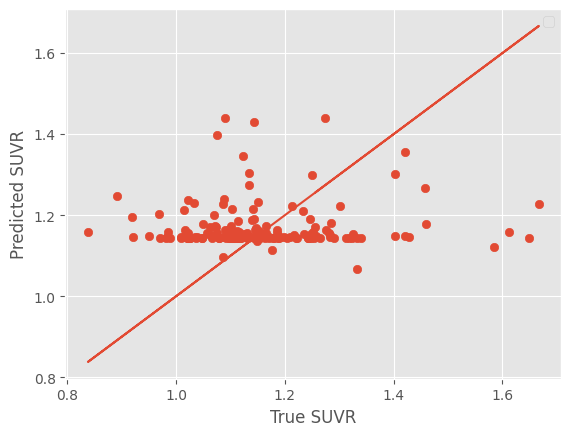

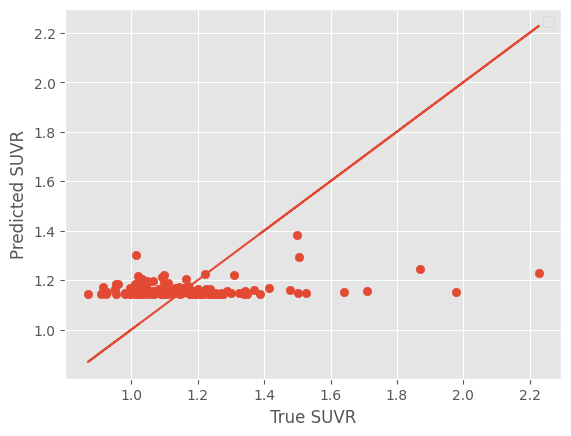

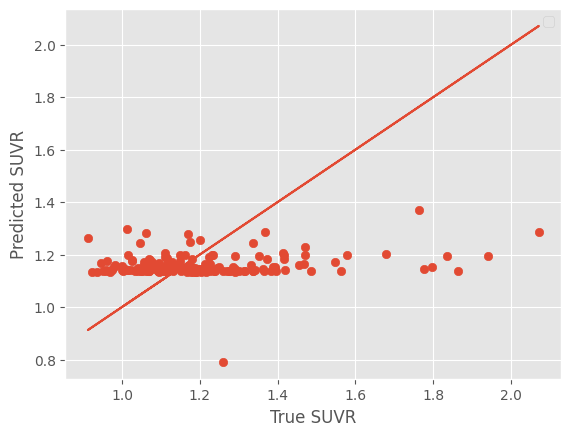

In [66]:
#PHC VSP
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME','PHC_VSP_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
  plt.legend()
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

# Ranking ROIs

In [67]:
df_nn = df.drop(columns=['INFERIORCEREBELLUM_SUVR'])
df_nn = df_nn.fillna(0)

target_cols = [col for col in df_nn.columns if 'PHC' in col]
feature_cols = [col for col in df_nn.columns if '_SUVR' in col]
print(feature_cols)


['ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARACENTRAL_SUVR', 'CTX_LH_PARAHIPPOCAMPAL_SUVR', 'CTX_LH_PARSOPERCULARIS_SUVR', 'CTX_LH_PARSORBITALIS_SUVR', 'CTX_LH_PARSTRIANGULARIS_SUVR', 'CTX_LH_PERICALCARINE_SUVR', 'CTX_LH_POSTCENTRAL_SUVR', 'CTX_LH_POSTERIORCI

In [69]:
def run_NN(d, tc, fc, k = 5, rs = 20, lr = 0.001, nre = 100):
  ksplit = k
  RMSE_NN = np.zeros(ksplit)
  kf = KFold(n_splits=ksplit, shuffle=True, random_state=rs)   # setting random_state for repeatable results

  train_folds = []
  test_folds = []

  for i, (train, test) in enumerate(kf.split(d)):
      train_folds.append(d.iloc[train])
      test_folds.append(d.iloc[test])

  # Run Model
  for i in range(ksplit):
    train_ds = train_folds[i]
    test_ds = test_folds[i]
    input_size = 118
    batch_size = 10
    train_pt_ds = PandasDataset(train_ds, feature_cols=fc, target_col=tc)
    test_pt_ds = PandasDataset(test_ds, feature_cols=fc, target_col=tc)
    train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
    test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
    model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
    print(model)
    learning_rate = lr
    nr_epochs = nre
    eval_every = 5
    loss_f = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
    RMSE_NN[i]= eval_model_historic(model,test_dl)
    print("RMSE for Epoch " + str(i) + " : " + str(eval_model_historic(model,test_dl)))
  return model, np.mean(RMSE_NN)

In [70]:
standardModel, rmseVal = run_NN(df_nn, target_cols, feature_cols, k = 4)

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.48381441602340114
Epoch 5 loss 0.46534673158939066
Epoch 10 loss 0.45721600560041575
Epoch 15 loss 0.4593748069726504
Epoch 20 loss 0.46173004737267126
Epoch 25 loss 0.4578046977519989
Epoch 30 loss 0.45633813922221844
Epoch 35 loss 0.4595090049963731
Epoch 40 loss 0.4555355571783506
Epoch 45 loss 0.459983682173949
Epoch 50 loss 0.4545825738173265
Epoch 55 loss 0.45309774508843054
Epoch 60 loss 0.4563781316463764
Epoch 65 loss 0.45538595227094797
Epoch 70 loss 0.45539906804378216
Epoch 75 loss 0.453921914100647
Epoch 80 loss 0.45308330517548784
Epoch 85 loss 0.4535776725182166
Epoch 90 loss 0.4548817483278421
Epoch 95 loss 0.4556652036996988
Finished training!
[array([0.18281332], dtype=float32), array([-0.02250546], dtype=float32), array([0.26991457], dtype=flo

In [71]:
print(standardModel)
for param in standardModel.parameters():
  params = (param.data.numpy())
  break
max = np.zeros(4)
importance = np.zeros((4,len(feature_cols)))
print(feature_cols)
print(len(feature_cols))
print(params.shape)
ROIS = []
for i in range(4):
  max[i] = np.max(params[i,:])
  k= np.argmax(params[i,:])
  sorted_pos = np.argsort(params[i,:])
  print(feature_cols[112])
  for j in range(len(feature_cols)):
    importance[i, j] = list(sorted_pos).index(j)
  ROIS.append(feature_cols[k])

pos_mean = np.zeros(len(feature_cols))
pos_std = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  pos_mean[i] = np.mean(importance[:,i])
  pos_std[i] = np.std(importance[:,i])
for j in np.argsort(pos_mean):
  print(feature_cols[j] + ": Mean = " + str(pos_mean[j]) + ", Standard Deviation = " + str(pos_std[j]) + ", Importance = " + str(importance[:, j]))
print(ROIS)
print(target_cols)

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
['ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARA

In [72]:
for j in np.argsort(pos_mean):
  print(feature_cols[j] + ": Mean = " + str(pos_mean[j]) + ", Standard Deviation = " + str(pos_std[j]) + ", Importance = " + str(importance[:, j]))

CC_ANTERIOR_SUVR: Mean = 15.0, Standard Deviation = 15.215124054702938, Importance = [41. 10.  3.  6.]
LEFT_INF_LAT_VENT_SUVR: Mean = 16.25, Standard Deviation = 13.045593125649749, Importance = [32.  1.  6. 26.]
CTX_RH_TRANSVERSETEMPORAL_SUVR: Mean = 18.25, Standard Deviation = 12.457427503300993, Importance = [ 4. 13. 18. 38.]
CC_MID_ANTERIOR_SUVR: Mean = 25.0, Standard Deviation = 39.881073205218534, Importance = [94.  0.  1.  5.]
CTX_LH_BANKSSTS_SUVR: Mean = 26.0, Standard Deviation = 19.862024066041204, Importance = [12. 59. 24.  9.]
BRAINSTEM_SUVR: Mean = 26.25, Standard Deviation = 10.940178243520533, Importance = [13. 41. 19. 32.]
ERODED_SUBCORTICALWM_SUVR: Mean = 29.5, Standard Deviation = 34.630189141845584, Importance = [ 7. 88. 22.  1.]
RIGHT_LATERAL_VENTRICLE_SUVR: Mean = 29.5, Standard Deviation = 18.728320800328042, Importance = [47. 49.  7. 15.]
RIGHT_PUTAMEN_SUVR: Mean = 29.75, Standard Deviation = 16.723860200324566, Importance = [29. 27. 55.  8.]
CTX_LH_PARACENTRAL_S

# Classifiers for each PHC Score

In [73]:
fs_overall = [None] * len(feature_cols)
fs_mem = [None] * len(feature_cols)
fs_exf = [None] * len(feature_cols)
fs_lan = [None] * len(feature_cols)
fs_vsp = [None] * len(feature_cols)

vols_overall = [None] * len(feature_cols)
vols_mem = [None] * len(feature_cols)
vols_exf = [None] * len(feature_cols)
vols_lan = [None] * len(feature_cols)
vols_vsp = [None] * len(feature_cols)

for i in np.argsort(pos_mean):
  fs_overall[i] = feature_cols[i]
  vols_overall[i] = fs_overall[i].replace('_SUVR', '_VOLUME')


for i in range(len(feature_cols)):
  fs_mem[i] = feature_cols[int(importance[0, i])]
  vols_mem[i] = fs_mem[i].replace('_SUVR', '_VOLUME')
  fs_exf[i] = feature_cols[int(importance[1, i])]
  vols_exf[i] = fs_exf[i].replace('_SUVR', '_VOLUME')
  fs_lan[i] = feature_cols[int(importance[2, i])]
  vols_lan[i] = fs_lan[i].replace('_SUVR', '_VOLUME')
  fs_vsp[i] = feature_cols[int(importance[3, i])]
  vols_vsp[i] = fs_vsp[i].replace('_SUVR', '_VOLUME')
print(target_cols)

['PHC_MEM_mannualJoin', 'PHC_EXF_mannualJoin', 'PHC_LAN_mannualJoin', 'PHC_VSP_mannualJoin']


In [74]:
df_classifier_train = df_nn.sample(frac=0.8)
df_classifier_test = df_nn.drop(df_classifier_train.index)

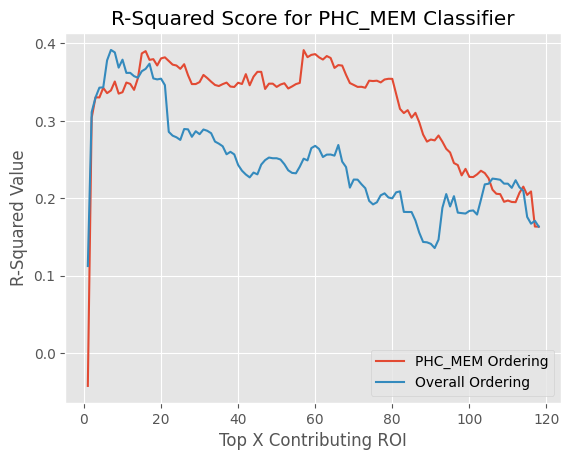

56
0.39135209938555027
6
0.39158042822278194


In [75]:
# MEM PHC Classifier
import pandas
from sklearn import linear_model, metrics

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_mem_m = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  mem_regr = linear_model.LinearRegression()
  mem_regr.fit(df_classifier_train[fs_mem[0:i+1] + vols_mem[0:i+1]], df_classifier_train[target_cols[0]])
  prediction = mem_regr.predict(df_classifier_test[fs_mem[0:i+1] + vols_mem[0:i+1]])
  r2_arr_mem_m[i] = metrics.r2_score(df_classifier_test[target_cols[0]].to_numpy(), prediction)

r2_arr_mem_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  mem_regr = linear_model.LinearRegression()
  mem_regr.fit(df_classifier_train[fs_overall[0:i+1] + vols_overall[0:i+1]], df_classifier_train[target_cols[0]])
  prediction = mem_regr.predict(df_classifier_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  r2_arr_mem_o[i] = metrics.r2_score(df_classifier_test[target_cols[0]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_mem_m, label = "PHC_MEM Ordering")
plt.plot(list(range(1, 119)), r2_arr_mem_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_MEM Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_mem_m.argmax())
print(r2_arr_mem_m.max())
print(r2_arr_mem_o.argmax())
print(r2_arr_mem_o.max())

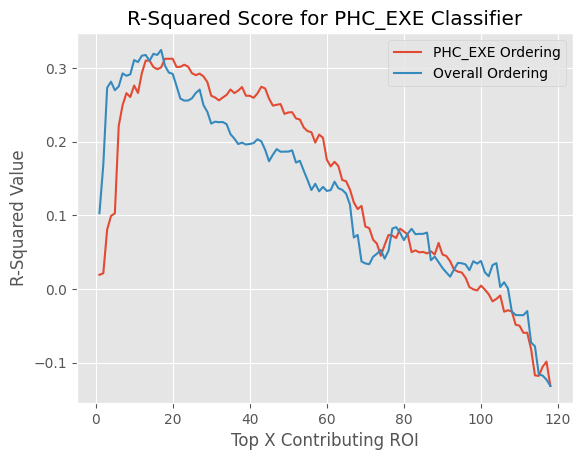

19
0.3126412598542354
16
0.3246169225865966


In [76]:
# EXF PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_exf_e = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  exf_regr = linear_model.LinearRegression()
  exf_regr.fit(df_classifier_train[fs_exf[0:i+1] + vols_exf[0:i+1]], df_classifier_train[target_cols[1]])
  prediction = exf_regr.predict(df_classifier_test[fs_exf[0:i+1] + vols_exf[0:i+1]])
  r2_arr_exf_e[i] = metrics.r2_score(df_classifier_test[target_cols[1]].to_numpy(), prediction)

r2_arr_exf_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  exf_regr = linear_model.LinearRegression()
  exf_regr.fit(df_classifier_train[fs_overall[0:i+1]+vols_overall[0:i+1]], df_classifier_train[target_cols[1]])
  prediction = exf_regr.predict(df_classifier_test[fs_overall[0:i+1]+vols_overall[0:i+1]])
  r2_arr_exf_o[i] = metrics.r2_score(df_classifier_test[target_cols[1]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_exf_e, label = "PHC_EXE Ordering")
plt.plot(list(range(1, 119)), r2_arr_exf_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_EXE Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_exf_e.argmax())
print(r2_arr_exf_e.max())
print(r2_arr_exf_o.argmax())
print(r2_arr_exf_o.max())

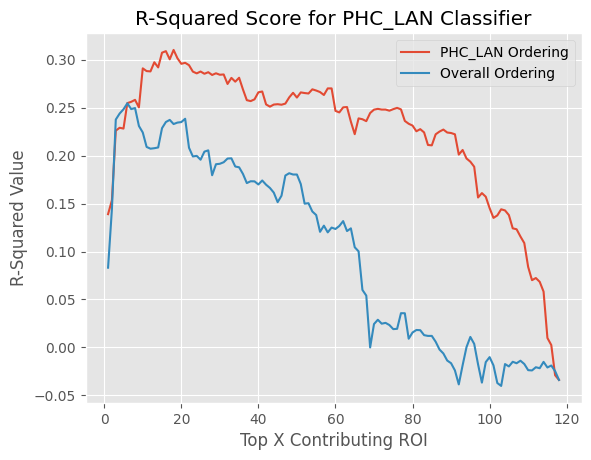

17
0.31010083267800925
5
0.2544844289584286


In [77]:
# LAN PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_lan_l = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  lan_regr = linear_model.LinearRegression()
  lan_regr.fit(df_classifier_train[fs_lan[0:i+1] + vols_lan[0:i+1]], df_classifier_train[target_cols[2]])
  prediction = lan_regr.predict(df_classifier_test[fs_lan[0:i+1]+vols_lan[0:i+1]])
  r2_arr_lan_l[i] = metrics.r2_score(df_classifier_test[target_cols[2]].to_numpy(), prediction)

r2_arr_lan_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  lan_regr = linear_model.LinearRegression()
  lan_regr.fit(df_classifier_train[fs_overall[0:i+1]+vols_overall[0:i+1]], df_classifier_train[target_cols[2]])
  prediction = lan_regr.predict(df_classifier_test[fs_overall[0:i+1]+vols_overall[0:i+1]])
  r2_arr_lan_o[i] = metrics.r2_score(df_classifier_test[target_cols[2]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_lan_l, label = "PHC_LAN Ordering")
plt.plot(list(range(1, 119)), r2_arr_lan_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_LAN Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_lan_l.argmax())
print(r2_arr_lan_l.max())
print(r2_arr_lan_o.argmax())
print(r2_arr_lan_o.max())

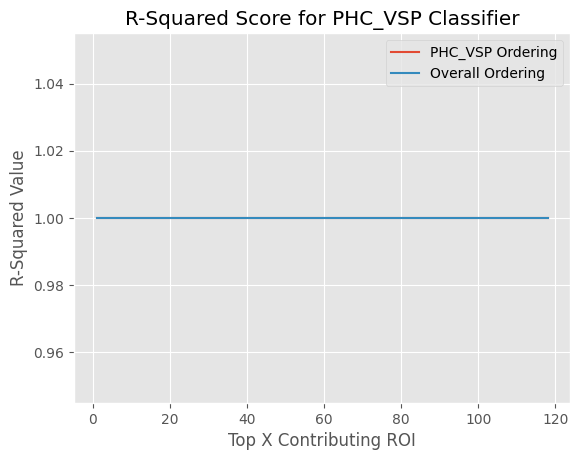

0
1.0
0
1.0


In [78]:
# VSP PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_vsp_v = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  vsp_regr = linear_model.LinearRegression()
  vsp_regr.fit(df_classifier_train[fs_vsp[0:i+1] + vols_vsp[0:i+1]], df_classifier_train[target_cols[3]])
  prediction = vsp_regr.predict(df_classifier_test[fs_vsp[0:i+1] + vols_vsp[0:i+1]])
  r2_arr_vsp_v[i] = metrics.r2_score(df_classifier_test[target_cols[3]].to_numpy(), prediction)

r2_arr_vsp_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  vsp_regr = linear_model.LinearRegression()
  vsp_regr.fit(df_classifier_train[fs_overall[0:i+1] + vols_overall[0:i+1]], df_classifier_train[target_cols[3]])
  prediction = vsp_regr.predict(df_classifier_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  r2_arr_vsp_o[i] = metrics.r2_score(df_classifier_test[target_cols[3]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_vsp_v, label = "PHC_VSP Ordering")
plt.plot(list(range(1, 119)), r2_arr_vsp_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_VSP Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_vsp_v.argmax())
print(r2_arr_vsp_v.max())
print(r2_arr_vsp_o.argmax())
print(r2_arr_vsp_o.max())

# CN/MCI-AD Classifier

In [79]:
cognitionDF = pd.concat([df_nn[df_nn['dx_current.tau'] == 'CN'], df_nn[df_nn['dx_current.tau'] == 'MCI-AD']])
cognitionDF['dx_current.tau'].replace('CN', 0, inplace=True)
cognitionDF['dx_current.tau'].replace('MCI-AD', 1, inplace=True)
cognitionDF_train = cognitionDF.sample(frac=0.8)
cognitionDF_test = cognitionDF.drop(cognitionDF_train.index)

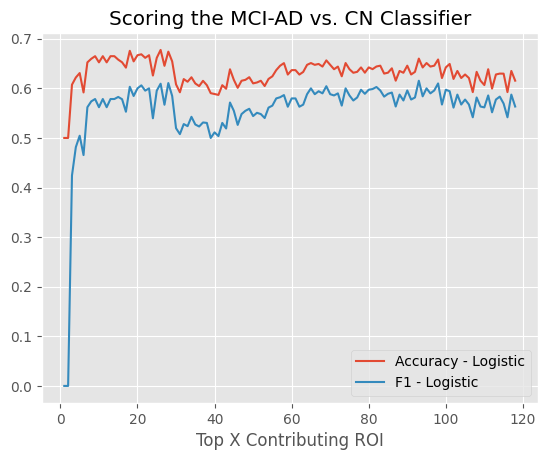

25
0.6775075987841945
92
0.6153846153846154


In [80]:
import pandas
from sklearn import linear_model, metrics

f1_cognitionLog = np.zeros(len(feature_cols))
accuracy_cognitionLog = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  cogntion_regr = linear_model.LogisticRegression()
  cogntion_regr.fit(cognitionDF_train[fs_overall[0:i+1] + vols_overall[0:i+1]], cognitionDF_train['dx_current.tau'])
  prediction = cogntion_regr.predict(cognitionDF_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  # print('Prediction:')
  # print(prediction)
  # print('Truth:')
  # print(cognitionDF_test['dx_current.tau'].to_numpy())
  f1_cognitionLog[i] = metrics.f1_score(cognitionDF_test['dx_current.tau'].to_numpy(), prediction)
  accuracy_cognitionLog[i] = metrics.balanced_accuracy_score(cognitionDF_test['dx_current.tau'].to_numpy(), prediction)
plt.plot(list(range(1, 119)), accuracy_cognitionLog, label="Accuracy - Logistic")
plt.plot(list(range(1, 119)), f1_cognitionLog, label="F1 - Logistic")
plt.title("Scoring the MCI-AD vs. CN Classifier")
plt.xlabel('Top X Contributing ROI')
plt.legend()
plt.show()
print(accuracy_cognitionLog.argmax())
print(accuracy_cognitionLog.max())
print(f1_cognitionLog.argmax())
print(f1_cognitionLog.max())